Adapted from [ner_with_bilstm_and_crf](https://www.kaggle.com/nikkisharma536/ner-with-bilstm-and-crf/notebook)
Altigran Soares da Silva
IComp/UFAM - 15/03/2021


In [ ]:
# For this to work, use:
# Keras 2.3.1
# Also remember to use GPU in your colab notebook
%tensorflow_version 2.x

# Code to read csv file into Colaboratory:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

from math import nan
from future.utils import iteritems
import matplotlib.pyplot as plt
import numpy as np
import math
import random
import json
import pickle
import time
from requests import get

import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import torch
from torch import cuda
from torch.utils.data import Dataset, DataLoader

!pip install sentencepiece
!pip install transformers
from transformers import BertForTokenClassification, AutoTokenizer

!pip install seqeval
from seqeval.metrics import f1_score, classification_report

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# Code to read csv file from google drive into Colaboratory:
DATA_TRAINING_FILE_ID = '1iTLWWB9aFjtjVz7Kq4ku2syjhINCz2_q'
DATA_TRAINING_FILENAME = 'ner_training_dataset.csv'
DATA_DEV_FILE_ID = '1fB1Mp-6_zxGC3NO5sMX23B-LPyYzc9I9'
DATA_DEV_FILENAME = 'ner_validation_dataset.csv'
DATA_TEST_FILE_ID = '17vmu2VXPwvOKuQ66kDY7t38dFqkYccvx'
DATA_TEST_FILENAME = 'ner_test_dataset.csv'
BACKUP_FOLDER_ID = '1EwDUGjrtg8AiUhBFAImg5vEUXxYEqQcS'

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)
downloaded_training = drive.CreateFile({'id': DATA_TRAINING_FILE_ID})
downloaded_training.GetContentFile(DATA_TRAINING_FILENAME)
downloaded_dev = drive.CreateFile({'id': DATA_DEV_FILE_ID})
downloaded_dev.GetContentFile(DATA_DEV_FILENAME)
downloaded_test = drive.CreateFile({'id': DATA_TEST_FILE_ID})
downloaded_test.GetContentFile(DATA_TEST_FILENAME)

# Read the csv file in a dataframe called "data"
training_data = pd.read_csv(DATA_TRAINING_FILENAME, encoding="latin1")
dev_data = pd.read_csv(DATA_DEV_FILENAME, encoding="latin1")
test_data = pd.read_csv(DATA_TEST_FILENAME, encoding="latin1")
# Fill NaN values using the specified method
# Ffill propagate last valid observation/value forward to next valid 
training_data = training_data.fillna(method="ffill")
dev_data = dev_data.fillna(method="ffill")
test_data = test_data.fillna(method="ffill")

notebook_filename = get('http://172.28.0.2:9000/api/sessions').json()[0]['name']

In [ ]:
# Explore the input dataset
print("Number of training sentences: ", len(training_data.groupby(['Sentence #'])))
print("Number of dev sentences: ", len(dev_data.groupby(['Sentence #'])))
print("Number of test sentences: ", len(test_data.groupby(['Sentence #'])))

training_words = list(set(training_data["Word"].values))
n_training_words = len(training_words)
print("Number of words in the training dataset: ", n_training_words)
dev_words = list(set(dev_data["Word"].values))
n_dev_words = len(dev_words)
print("Number of words in the dev dataset: ", n_dev_words)
test_words = list(set(test_data["Word"].values))
n_test_words = len(test_words)
print("Number of words in the test dataset: ", n_test_words)

training_tags = list(set(training_data["Tag"].values))
print("Tags in the training dataset:", training_tags)
n_training_tags = len(training_tags)
print("Number of Labels in the training dataset: ", n_training_tags)
dev_tags = list(set(dev_data["Tag"].values))
print("Tags in the dev dataset:", dev_tags)
n_dev_tags = len(dev_tags)
print("Number of Labels in the dev dataset: ", n_dev_tags)
test_tags = list(set(test_data["Tag"].values))
print("Tags in the test dataset:", test_tags)
n_test_tags = len(test_tags)
print("Number of Labels in the test dataset: ", n_test_tags)

print("What the training dataset looks like:")
# Show the first 10 rows
training_data.head(n=10)

Number of training sentences:  1000
Number of dev sentences:  1000
Number of test sentences:  1000
Number of words in the training dataset:  10405
Number of words in the dev dataset:  10246
Number of words in the test dataset:  10814
Tags in the training dataset: ['O', 'B-Disease', 'I-Chemical', 'B-Chemical', 'I-Disease']
Number of Labels in the training dataset:  5
Tags in the dev dataset: ['O', 'B-Disease', 'I-Chemical', 'B-Chemical', 'I-Disease']
Number of Labels in the dev dataset:  5
Tags in the test dataset: ['O', 'B-Disease', 'I-Chemical', 'B-Chemical', 'I-Disease']
Number of Labels in the test dataset:  5
What the training dataset looks like:


,Sentence #,Word,Tag
0,Sentence: 1,Naloxone,B-Chemical
1,Sentence: 1,reverses,O
2,Sentence: 1,the,O
3,Sentence: 1,antihypertensive,O
4,Sentence: 1,effect,O
5,Sentence: 1,of,O
6,Sentence: 1,clonidine,B-Chemical
7,Sentence: 1,.,O
8,Sentence: 2,In,O
9,Sentence: 2,unanesthetized,O


In [ ]:
# SentenceGetter re-organize "data" as an arry of sentences
# Each sentence is a list of pairs <word,tag> 
class SentenceGetter(object):
    
    def __init__(self, dataset):
        self.n_sent = 1
        self.dataset = dataset
        self.empty = False
        agg_func = lambda s: [(w, t) for w,t in zip(s["Word"].values.tolist(),
                                                        s["Tag"].values.tolist())]
        self.grouped = self.dataset.groupby("Sentence #").apply(agg_func)
        self.sentences = [s for s in self.grouped]
    
    def get_next(self):
        try:
            s = self.grouped["Sentence: {}".format(self.n_sent)]
            self.n_sent += 1
            return s
        except:
            return None

training_getter = SentenceGetter(training_data)
training_sentences = training_getter.sentences
dev_getter = SentenceGetter(dev_data)
dev_sentences = dev_getter.sentences
test_getter = SentenceGetter(test_data)
test_sentences = test_getter.sentences

# Example: training sentence #200 
training_sentences[200]

[('Intravenous', 'O'),
 ('administration', 'O'),
 ('of', 'O'),
 ('prochlorperazine', 'B-Chemical'),
 ('by', 'O'),
 ('15', 'O'),
 ('-', 'O'),
 ('minute', 'O'),
 ('infusion', 'O'),
 ('versus', 'O'),
 ('2', 'O'),
 ('-', 'O'),
 ('minute', 'O'),
 ('bolus', 'O'),
 ('does', 'O'),
 ('not', 'O'),
 ('affect', 'O'),
 ('the', 'O'),
 ('incidence', 'O'),
 ('of', 'O'),
 ('akathisia', 'B-Disease'),
 (':', 'O'),
 ('a', 'O'),
 ('prospective', 'O'),
 (',', 'O'),
 ('randomized', 'O'),
 (',', 'O'),
 ('controlled', 'O'),
 ('trial', 'O'),
 ('.', 'O')]

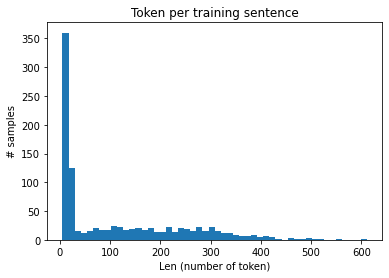

In [ ]:
# Explore set of sentences
# Plot sentences by length
plt.hist([len(s) for s in training_sentences], bins=50)
plt.title('Token per training sentence')
plt.xlabel('Len (number of token)')
plt.ylabel('# samples')
plt.show()

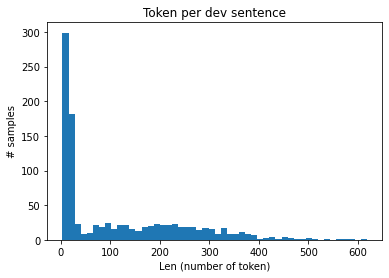

In [ ]:
# Explore set of sentences
# Plot sentences by length
plt.hist([len(s) for s in dev_sentences], bins=50)
plt.title('Token per dev sentence')
plt.xlabel('Len (number of token)')
plt.ylabel('# samples')
plt.show()

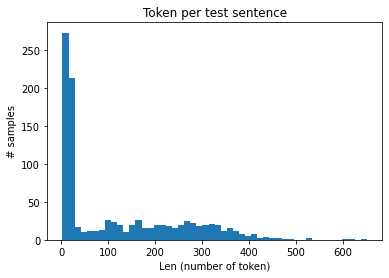

In [ ]:
# Explore set of sentences
# Plot sentences by length
plt.hist([len(s) for s in test_sentences], bins=50)
plt.title('Token per test sentence')
plt.xlabel('Len (number of token)')
plt.ylabel('# samples')
plt.show()

In [ ]:
# Keras (and most other ML packages) expect all the ids to be numeric, 
# this is an optimisation to save memory. 
# We will create the following dictionaries:
# word2idx: assign a numeric index to each word in the dataset
# idx2word: inverted version of word2idx
# tag2idx: assign a numeric index to each tag in the dataset
# idx2tag: inverted version of tag2idx

# Group training, dev and test data in order to create word-index dicts and to
# convert data to numeric indeces later
data = pd.concat([training_data, dev_data, test_data])

# words <= list of all words in the input dataset
words = list(set(data["Word"].values))
n_words = len(words)

# tags <= list of all tags in the input dataset
tags = []
for tag in set(data["Tag"].values):
    if tag is nan or isinstance(tag, float):
        tags.append('unk')
    else:
        tags.append(tag)
n_tags = len(tags)

# Dictionaries
word2idx = {w: i for i, w in enumerate(words)}
idx2word = {i: w for w, i in iteritems(word2idx)}
tag2idx = {t: i for i, t in enumerate(tags)}
idx2tag = {v: k for k, v in iteritems(tag2idx)}

# Index number for the word 'incidence'
print(word2idx['incidence'])
# Word of index 10
print(idx2word[10])
# Index number for the tag 'B-Disease'
print(tag2idx['B-Disease'])
# Tag of index 4
print(idx2tag[4])

12599
addressed
1
I-Disease


In [ ]:
# Convert train, dev and test data to numeric values
X_train = [[word2idx[w[0]] for w in s] for s in training_sentences]
y_train = [[tag2idx[w[1]] for w in s] for s in training_sentences]

X_dev = [[word2idx[w[0]] for w in s] for s in dev_sentences]
y_dev = [[tag2idx[w[1]] for w in s] for s in dev_sentences]

X_test = [[word2idx[w[0]] for w in s] for s in test_sentences]
y_test = [[tag2idx[w[1]] for w in s] for s in test_sentences]

In [ ]:
# Use this function to randomly remove some points from training dataset
# Use removal percentage in decimal value. E.g.: if you set as 0.5, it will
# remove 50% of the dataset

def random_remove_data_points(dataset, labels, removal_percentage):
    if removal_percentage < 0 or removal_percentage > 1:
        raise Exception("Invalid removal percentage")
    
    if removal_percentage == 1:
        raise Exception("You can't remove the entire dataset")
    
    number_of_points_remaining = round(len(dataset)*(1-removal_percentage))

    try_again = True

    while try_again:
      random_idxs = np.random.choice(len(dataset), number_of_points_remaining, replace=False)
      cut_dataset_sentences = [dataset[i] for i in random_idxs]
      cut_dataset_labels = [labels[i] for i in random_idxs]
      cut_tags = list(set([idx2tag[j] for sub in cut_dataset_labels for j in sub]))

      if all(i in cut_tags for i in tags if i[:2] == "B-"):
        try_again = False

    return cut_dataset_sentences, cut_dataset_labels 

print(f"Points in X_train before removal: {len(X_train)}")
print(f"Points in y_train before removal: {len(y_train)}")
# X_train, y_train = random_remove_data_points(X_train, y_train, 0.95)
print(f"Points in X_train before removal: {len(X_train)}")
print(f"Points in y_train before removal: {len(y_train)}")

Points in X_train before removal: 1000
Points in y_train before removal: 1000
Points in X_train before removal: 1000
Points in y_train before removal: 1000


In [ ]:
# Aux functions to save data and dicts, if data consistency is important
# and there is desire to not random split again

def save_backup_dataset(dataset, filename):
  dataset_df = pd.DataFrame(dataset)
  dataset_df.to_csv(filename, index=False)
  gfile = drive.CreateFile({'parents': [{'id': BACKUP_FOLDER_ID}]})
  gfile.SetContentFile(filename)
  gfile.Upload()

def save_backup_dict(dict, filename):
  dict_file = open(filename, "wb")
  pickle.dump(dict, dict_file)
  dict_file.close()
  gfile = drive.CreateFile({'parents': [{'id': BACKUP_FOLDER_ID}]})
  gfile.SetContentFile(filename)
  gfile.Upload()

In [ ]:
# Uncomment this cell if you want to save data for further use

# Check some points before saving
print(X_train[0])
print(y_train[0])
print(X_dev[0])
print(y_dev[0])
print(X_test[0])
print(y_test[0])
print(word2idx['incidence'])
print(tag2idx['B-Disease'])
print(idx2tag[2])
print(idx2word[100])
print(n_words)
print(n_tags)

X_train_filename = f'{notebook_filename}_X_train.csv'
y_train_filename = f'{notebook_filename}_y_train.csv'
X_dev_filename = f'{notebook_filename}_X_dev.csv'
y_dev_filename = f'{notebook_filename}_y_dev.csv'
X_test_filename = f'{notebook_filename}_X_test.csv'
y_test_filename = f'{notebook_filename}_y_test.csv'

word2idx_filename = f'{notebook_filename}_word2idx.pkl'
idx2word_filename = f'{notebook_filename}_idx2word.pkl'
tag2idx_filename = f'{notebook_filename}_tag2idx.pkl'
idx2tag_filename = f'{notebook_filename}_idx2tag.pkl'

others_filename = f'{notebook_filename}_others.pkl'

save_backup_dataset(X_train, X_train_filename)
save_backup_dataset(y_train, y_train_filename)
save_backup_dataset(X_dev, X_dev_filename)
save_backup_dataset(y_dev, y_dev_filename)
save_backup_dataset(X_test, X_test_filename)
save_backup_dataset(y_test, y_test_filename)

save_backup_dict(word2idx, word2idx_filename)
save_backup_dict(idx2word, idx2word_filename)
save_backup_dict(tag2idx, tag2idx_filename)
save_backup_dict(idx2tag, idx2tag_filename)

save_backup_dict({"n_words":n_words, "n_tags":n_tags}, others_filename)

[11090, 17807, 5891, 15208, 14127, 16787, 12005, 386]
[3, 0, 0, 0, 0, 0, 3, 0]
[9179, 7169, 927, 6605, 12909, 3343, 4537, 17386, 15203, 15188, 1007, 386]
[1, 4, 4, 0, 3, 2, 1, 0, 0, 0, 0, 0]
[16520, 11388, 9220, 5550, 386, 6084, 13610, 16787, 6645, 590, 386]
[3, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0]
12599
1
I-Chemical
today
18533
5


In [ ]:
# Uncomment this cell if you want to load saved data

# Re-import necessary libs
import pandas as pd
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
import pickle, math
from requests import get
import numpy as np
import matplotlib.pyplot as plt
import random
import time
%tensorflow_version 2.x
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import torch
from torch import cuda
from torch.utils.data import Dataset, DataLoader
!pip install sentencepiece
!pip install transformers
from transformers import BertForTokenClassification, AutoTokenizer
import matplotlib.pyplot as plt
!pip install seqeval
from seqeval.metrics import f1_score, classification_report

BACKUP_FOLDER_ID = '1EwDUGjrtg8AiUhBFAImg5vEUXxYEqQcS'
notebook_filename = get('http://172.28.0.2:9000/api/sessions').json()[0]['name']

X_train_filename = f'{notebook_filename}_X_train.csv'
y_train_filename = f'{notebook_filename}_y_train.csv'
X_dev_filename = f'{notebook_filename}_X_dev.csv'
y_dev_filename = f'{notebook_filename}_y_dev.csv'
X_test_filename = f'{notebook_filename}_X_test.csv'
y_test_filename = f'{notebook_filename}_y_test.csv'

word2idx_filename = f'{notebook_filename}_word2idx.pkl'
idx2word_filename = f'{notebook_filename}_idx2word.pkl'
tag2idx_filename = f'{notebook_filename}_tag2idx.pkl'
idx2tag_filename = f'{notebook_filename}_idx2tag.pkl'

others_filename = f'{notebook_filename}_others.pkl'

# Re-get important variables
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

def get_backup_files_ids(folder_id):
  file_list = drive.ListFile({'q': "'{}' in parents and trashed=false".format(folder_id)}).GetList()
  return file_list

def load_backup_dataset(file_id):
  downloaded = drive.CreateFile({'id':file_id})
  downloaded.GetContentFile(f"{file_id}.csv")

  dataset = pd.read_csv(f"{file_id}.csv", encoding="latin1")
  dataset = dataset.values.tolist()
  dataset = [ [ int(word) for word in sentence if str(word) != 'nan' ] for sentence in dataset]
  return dataset

def load_backup_dict(file_id):
  downloaded = drive.CreateFile({'id':file_id})
  downloaded.GetContentFile(f"{file_id}.pkl")

  dict_file = open(f"{file_id}.pkl", "rb")
  out_dict = pickle.load(dict_file)
  return out_dict

backup_file_list = get_backup_files_ids(BACKUP_FOLDER_ID)

X_train_file_id = [backup_file for backup_file in backup_file_list if backup_file['title'] == X_train_filename][0]['id']
y_train_file_id = [backup_file for backup_file in backup_file_list if backup_file['title'] == y_train_filename][0]['id']
X_dev_file_id = [backup_file for backup_file in backup_file_list if backup_file['title'] == X_dev_filename][0]['id']
y_dev_file_id = [backup_file for backup_file in backup_file_list if backup_file['title'] == y_dev_filename][0]['id']
X_test_file_id = [backup_file for backup_file in backup_file_list if backup_file['title'] == X_test_filename][0]['id']
y_test_file_id = [backup_file for backup_file in backup_file_list if backup_file['title'] == y_test_filename][0]['id']

word2idx_file_id = [backup_file for backup_file in backup_file_list if backup_file['title'] == word2idx_filename][0]['id']
idx2word_file_id = [backup_file for backup_file in backup_file_list if backup_file['title'] == idx2word_filename][0]['id']
tag2idx_file_id = [backup_file for backup_file in backup_file_list if backup_file['title'] == tag2idx_filename][0]['id']
idx2tag_file_id = [backup_file for backup_file in backup_file_list if backup_file['title'] == idx2tag_filename][0]['id']

others_file_id = [backup_file for backup_file in backup_file_list if backup_file['title'] == others_filename][0]['id']

X_train = load_backup_dataset(X_train_file_id)
y_train = load_backup_dataset(y_train_file_id)
X_dev = load_backup_dataset(X_dev_file_id)
y_dev = load_backup_dataset(y_dev_file_id)
X_test = load_backup_dataset(X_test_file_id)
y_test = load_backup_dataset(y_test_file_id)

word2idx = load_backup_dict(word2idx_file_id)
idx2word = load_backup_dict(idx2word_file_id)
tag2idx = load_backup_dict(tag2idx_file_id)
idx2tag = load_backup_dict(idx2tag_file_id)

others = load_backup_dict(others_file_id)

n_words = others["n_words"]
n_tags = others["n_tags"]

# Check some points after loading data to see if they match the ones before saving
print(X_train[0])
print(y_train[0])
print(X_dev[0])
print(y_dev[0])
print(X_test[0])
print(y_test[0])
print(word2idx['incidence'])
print(tag2idx['B-Disease'])
print(idx2tag[2])
print(idx2word[100])
print(n_words)
print(n_tags)

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.3 MB 14.9 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.7 MB 14.3 MB/s 
     |████████████████████████████████| 6.6 MB 42.3 MB/s 
     |████████████████████████████████| 120 kB 48.7 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 43 kB 2.2 MB/s 
  Created wheel for seqeval: filename=seqeval-1.2.2-py3-none-any.whl size=16180 sha256=6defa8af02a0ffd1fda4c33c46790419a7be99ba9f4662eaf081c4ffd3a85769
  Stored in directory: /root/.cache/pip/wheels/05/96/ee/7cac4e74f3b19e3158dce26a20a1c86b3533c43ec72a549fd7
Successfully built seqeval
[11090, 17807, 5891, 15208, 14127, 16787, 12005, 386]
[3, 

In [ ]:
# Aux function to help in augmentation. Generates a dict where entities
# are the keys, and words are the values.

def create_entities_dict(dataset, labels, decoded_word=False):
    entities_dict = {}
    
    for i, sentence in enumerate(dataset):
        for k, word in enumerate(sentence):
            tag = idx2tag[labels[i][k]]
            if tag[:2] == "B-":
                if decoded_word:
                    word_list = [idx2word[word]]
                else:
                    word_list = [word]
                j = k + 1
                if j < len(labels[i]):
                    while idx2tag[labels[i][j]][:2] == "I-":
                        if decoded_word:
                            word_list.append(idx2word[dataset[i][j]])
                        else:
                            word_list.append(dataset[i][j])
                        j = j+1
                        if j == len(labels[i]):
                            break
                        
                if entities_dict.get(tag):
                    if word_list not in entities_dict[tag]:
                        entities_dict[tag].append(word_list)
                else:
                    entities_dict[tag] = [word_list]
                    
    return entities_dict

entities_dict = create_entities_dict(X_train, y_train)

In [ ]:
# Augmentation function using entity replacement technique.
# It will generate a new dataset, with X% more points based on
# the original dataset. E.g.: if you set augmentation percentage as 0.5 and dataset has
# 1000 points, it will generate a dataset with 1500 points.

def generate_sentences(dataset, labels, entities_dict, augmented_set_size_percentage):
    if augmented_set_size_percentage < 0:
        raise Exception("Invalid augmented set size percentage")

    number_of_new_sentences = math.ceil(augmented_set_size_percentage * len(dataset))
    random_idxs = np.random.choice(len(dataset), number_of_new_sentences, replace=True)
    
    base_sequences = [dataset[i] for i in random_idxs]
    base_labels = [labels[i] for i in random_idxs]

    new_sequences = []
    new_labels = []
    
    for k, sequence in enumerate(base_sequences):
        new_sequence = []
        new_label = []

        for i, word in enumerate(sequence):
            tag = idx2tag[base_labels[k][i]]
            if tag == "O":
                new_sequence.append(word)
                new_label.append(base_labels[k][i])
            elif tag[:2] == "B-":
                same_entities_type_tmp = entities_dict[tag]
                same_entities_type = np.array(same_entities_type_tmp, dtype=object)
                random_entity_idx = np.random.choice(len(same_entities_type), 1)[0]
                random_entity = same_entities_type[random_entity_idx]
                random_number_of_tokens = random.randint(1, len(random_entity))
                random_entity_tokens = np.random.choice(random_entity, random_number_of_tokens, replace = False).tolist()
                entity = tag[2:]
                decoded_token_labels = [f"I-{entity}" for token in random_entity_tokens]
                decoded_token_labels[0] = tag
                encoded_token_labels = [tag2idx[label] for label in decoded_token_labels]
                new_sequence = new_sequence + random_entity_tokens
                new_label = new_label + encoded_token_labels

        new_sequences.append(new_sequence)
        new_labels.append(new_label)

    augmented_X_train = dataset + new_sequences
    augmented_y_train = labels + new_labels

    print(f"Points in X_train after augmentation: {len(augmented_X_train)}")
    print(f"Points in y_train after augmentation: {len(augmented_y_train)}")

    return augmented_X_train, augmented_y_train

In [ ]:
tokenizer = AutoTokenizer.from_pretrained("allenai/scibert_scivocab_uncased")

class dataset(Dataset):
  def __init__(self, dataframe, tokenizer, max_len):
        self.len = len(dataframe)
        self.data = dataframe
        self.tokenizer = tokenizer
        self.max_len = max_len

  def __getitem__(self, index):
        # step 1: get the sentence and word labels
        sentence = self.data.sentence[index]
        word_labels = self.data.word_labels[index].split(",") 

        # step 2: use tokenizer to encode sentence (includes padding/truncation up to max length)
        # BertTokenizerFast provides a handy "return_offsets_mapping" functionality for individual tokens
        encoding = self.tokenizer(sentence,
                             is_split_into_words=True,
                             return_offsets_mapping=True, 
                             padding='max_length', 
                             truncation=True, 
                             max_length=self.max_len)
        
        # step 3: create token labels only for first word pieces of each tokenized word
        labels = [tag2idx[label] for label in word_labels] 
        # code based on https://huggingface.co/transformers/custom_datasets.html#tok-ner
        # create an empty array of -100 of length max_length
        encoded_labels = np.ones(len(encoding["offset_mapping"]), dtype=int) * -100
        
        # set only labels whose first offset position is 0 and the second is not 0
        i = 0
        for idx, mapping in enumerate(encoding["offset_mapping"]):
          if mapping[0] == 0 and mapping[1] != 0:
            # overwrite label
            encoded_labels[idx] = labels[i]
            i += 1

        # step 4: turn everything into PyTorch tensors
        item = {key: torch.as_tensor(val) for key, val in encoding.items()}
        item['labels'] = torch.as_tensor(encoded_labels)
        
        return item

  def __len__(self):
        return self.len

In [ ]:
# some configuration variables
LEARNING_RATE = 5e-05
MAX_GRAD_NORM = 10
TRAINING_STOP_LOSS_PERCENTAGE = 1

# Model creation function
def create_model(maxlen, n_labels, training_set, testing_set, validation_set):
  device = 'cuda' if cuda.is_available() else 'cpu'
  print("Device: ", device)

  model = BertForTokenClassification.from_pretrained('allenai/scibert_scivocab_uncased', num_labels=n_labels)
  model.to(device)

  optimizer = torch.optim.Adam(params=model.parameters(), lr=LEARNING_RATE)

  TRAIN_BATCH_SIZE = round(0.05*len(training_set))
  if TRAIN_BATCH_SIZE > 16:
    TRAIN_BATCH_SIZE = 16
  if TRAIN_BATCH_SIZE < 10:
    TRAIN_BATCH_SIZE = 10

  VALID_BATCH_SIZE = round(0.1*len(validation_set))
  if VALID_BATCH_SIZE > 16:
    VALID_BATCH_SIZE = 16
  if VALID_BATCH_SIZE < 10:
    VALID_BATCH_SIZE = 10

  train_params = {'batch_size': TRAIN_BATCH_SIZE,
                  'shuffle': True,
                  'num_workers': 0
                  }

  test_params = {'batch_size': VALID_BATCH_SIZE,
                  'shuffle': True,
                  'num_workers': 0
                  }

  training_loader = DataLoader(training_set, **train_params)
  testing_loader = DataLoader(testing_set, **test_params)
  validation_loader = DataLoader(validation_set, **test_params)

  return model, device, optimizer, training_loader, testing_loader, validation_loader

In [ ]:
# Model training function
def train(model, device, optimizer, training_loader, epoch, training_stop_loss_percentage):
    tr_loss, tr_accuracy = 0, 0
    nb_tr_examples, nb_tr_steps = 0, 0
    tr_preds, tr_labels = [], []
    losses = []
    # put model in training mode
    model.train()
    
    for idx, batch in enumerate(training_loader):
        
        ids = batch['input_ids'].to(device, dtype = torch.long)
        mask = batch['attention_mask'].to(device, dtype = torch.long)
        labels = batch['labels'].to(device, dtype = torch.long)

        loss, tr_logits = model(input_ids=ids, attention_mask=mask, labels=labels, return_dict = False)
        tr_loss += loss.item()

        nb_tr_steps += 1
        nb_tr_examples += labels.size(0)
        
        if idx % 100==0:
            loss_step = tr_loss/nb_tr_steps
            print(f"Training loss per 100 training steps: {loss_step}")
            losses.append(loss_step)
            last_5_losses = losses[-5:]
            loss_min = min(last_5_losses)
            loss_max = max(last_5_losses)
            if len(last_5_losses) > 1 and (loss_max - loss_min)/loss_max < training_stop_loss_percentage/100:
              print("Stopping epoch...")
              break
           
        # compute training accuracy
        flattened_targets = labels.view(-1) # shape (batch_size * seq_len,)
        active_logits = tr_logits.view(-1, model.num_labels) # shape (batch_size * seq_len, num_labels)
        flattened_predictions = torch.argmax(active_logits, axis=1) # shape (batch_size * seq_len,)
        
        # only compute accuracy at active labels
        active_accuracy = labels.view(-1) != -100 # shape (batch_size, seq_len)
        #active_labels = torch.where(active_accuracy, labels.view(-1), torch.tensor(-100).type_as(labels))
        
        labels = torch.masked_select(flattened_targets, active_accuracy)
        predictions = torch.masked_select(flattened_predictions, active_accuracy)
        
        tr_labels.extend(labels)
        tr_preds.extend(predictions)

        tmp_tr_accuracy = accuracy_score(labels.cpu().numpy(), predictions.cpu().numpy())
        tr_accuracy += tmp_tr_accuracy
    
        # gradient clipping
        torch.nn.utils.clip_grad_norm_(
            parameters=model.parameters(), max_norm=MAX_GRAD_NORM
        )
        
        # backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    epoch_loss = tr_loss / nb_tr_steps
    tr_accuracy = tr_accuracy / nb_tr_steps
    print(f"Training loss epoch: {epoch_loss}")
    print(f"Training accuracy epoch: {tr_accuracy}")

In [ ]:
# Model testing function
def test(model, device, testing_loader):
    print("Validating model...")
    # put model in evaluation mode
    model.eval()
    
    eval_loss, eval_accuracy = 0, 0
    nb_eval_examples, nb_eval_steps = 0, 0
    eval_preds, eval_labels = [], []
    
    with torch.no_grad():
        for idx, batch in enumerate(testing_loader):
            
            ids = batch['input_ids'].to(device, dtype = torch.long)
            mask = batch['attention_mask'].to(device, dtype = torch.long)
            labels = batch['labels'].to(device, dtype = torch.long)
            
            loss, eval_logits = model(input_ids=ids, attention_mask=mask, labels=labels, return_dict = False)
            
            eval_loss += loss.item()

            nb_eval_steps += 1
            nb_eval_examples += labels.size(0)
        
            # compute evaluation accuracy
            flattened_targets = labels.view(-1) # shape (batch_size * seq_len,)
            active_logits = eval_logits.view(-1, model.num_labels) # shape (batch_size * seq_len, num_labels)
            flattened_predictions = torch.argmax(active_logits, axis=1) # shape (batch_size * seq_len,)
            
            # only compute accuracy at active labels
            active_accuracy = labels.view(-1) != -100 # shape (batch_size, seq_len)
        
            labels = torch.masked_select(flattened_targets, active_accuracy)
            predictions = torch.masked_select(flattened_predictions, active_accuracy)
            
            eval_labels.extend(labels)
            eval_preds.extend(predictions)
            
            tmp_eval_accuracy = accuracy_score(labels.cpu().numpy(), predictions.cpu().numpy())
            eval_accuracy += tmp_eval_accuracy

    labels = [idx2tag[id.item()] for id in eval_labels]
    predictions = [idx2tag[id.item()] for id in eval_preds]
    
    eval_loss = eval_loss / nb_eval_steps
    eval_accuracy = eval_accuracy / nb_eval_steps
    print(f"Validation Loss: {eval_loss}")
    print(f"Validation Accuracy: {eval_accuracy}")

    return labels, predictions, eval_loss

In [ ]:
def create_train_and_validate_model(augmented_percentage):

  augmented_X_train, augmented_y_train = generate_sentences(X_train, y_train, entities_dict, augmented_percentage)

  maxlen_X_train = max([len(s) for s in augmented_X_train])
  maxlen_X_test = max([len(s) for s in X_test])
  maxlen_X_dev = max([len(s) for s in X_dev])
  maxlen_y_train = max([len(s) for s in augmented_y_train])
  maxlen_y_test = max([len(s) for s in y_test])
  maxlen_y_dev = max([len(s) for s in y_dev])

  maxlen = max([maxlen_X_train, maxlen_X_test, maxlen_X_dev, maxlen_y_train, maxlen_y_test, maxlen_y_dev])

  if maxlen > 512:
    maxlen = 512

  augmented_X_train_words = [[idx2word[word] for word in sentence] for sentence in augmented_X_train]
  X_dev_words = [[idx2word[word] for word in sentence] for sentence in X_dev]
  X_test_words = [[idx2word[word] for word in sentence] for sentence in X_test]
  augmented_y_train_tags = [','.join([idx2tag[tag] for tag in sentence]) for sentence in augmented_y_train]
  y_dev_tags = [','.join([idx2tag[tag] for tag in sentence]) for sentence in y_dev]
  y_test_tags = [','.join([idx2tag[tag] for tag in sentence]) for sentence in y_test]

  new_train_df = pd.DataFrame({"sentence": augmented_X_train_words, "word_labels": augmented_y_train_tags}).reset_index(drop=True)
  new_test_df = pd.DataFrame({"sentence": X_test_words, "word_labels": y_test_tags}).reset_index(drop=True)
  new_val_df = pd.DataFrame({"sentence": X_dev_words, "word_labels": y_dev_tags}).reset_index(drop=True)

  training_set = dataset(new_train_df, tokenizer, maxlen)
  testing_set = dataset(new_test_df, tokenizer, maxlen)
  validation_set = dataset(new_val_df, tokenizer, maxlen)

  model, device, optimizer, training_loader, testing_loader, val_loader = create_model(maxlen, len(tag2idx), training_set, testing_set, validation_set)

  training_start_time = time.clock()
  min_val_loss = 0
  MAX_PATIENCE = 5
  patience = 0

  for epoch in range(100):
    print(f"Training epoch: {epoch + 1}")
    if patience == MAX_PATIENCE:
      print("Patience limit reached")
      break
    train(model, device, optimizer, training_loader, epoch, TRAINING_STOP_LOSS_PERCENTAGE)
    labels, predictions, val_loss = test(model, device, val_loader)
    if ((min_val_loss == 0) or (min_val_loss != 0 and val_loss < min_val_loss)):
      min_val_loss = val_loss
      torch.save(model.state_dict(), 'checkpoint.pt')
      patience = 0
    else:
      patience = patience + 1
  print(f"Training duration: {(time.clock() - training_start_time)/60} minutes")

  checkpoint = torch.load('checkpoint.pt')
  model.load_state_dict(checkpoint)

  validation_start_time = time.clock()
  labels, predictions, test_loss = test(model, device, testing_loader)
  labels = [labels]
  predictions = [predictions]
  print(f"Validation duration: {(time.clock() - validation_start_time)/60} minutes")

  print("F1-score (test): {:.1%}".format(f1_score(labels, predictions)))
  print(classification_report(labels, predictions))

In [ ]:
number_of_training_models = 10
target_augmented_percentage = 0

print(f"!!!!!! Augmented Percentage {target_augmented_percentage*100}% !!!!!!")

for i in range(number_of_training_models):
  print(f"!!!!!! Starting model number {i+1} !!!!!!")
  create_train_and_validate_model(target_augmented_percentage)

!!!!!! Augmented Percentage 0% !!!!!!
!!!!!! Starting model number 1 !!!!!!
Points in X_train after augmentation: 1000
Points in y_train after augmentation: 1000
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.decoder.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 1.4576208591461182
Training loss epoch: 0.2019685652284395
Training accuracy epoch: 0.9390295971621093
Validating model...
Validation Loss: 0.08001559925457788
Validation Accuracy: 0.9717804937506331
Training epoch: 2
Training loss per 100 training steps: 0.0467320941388607
Training loss epoch: 0.06089165629375549
Training accuracy epoch: 0.9794044797997279
Validating model...
Validation Loss: 0.07028033303481246
Validation Accuracy: 0.9762260025596405
Training epoch: 3
Training loss per 100 training steps: 0.021162230521440506
Training loss epoch: 0.03186819143593311
Training accuracy epoch: 0.9897336387910362
Validating model...
Validation Loss: 0.07037847361985654
Validation Accuracy: 0.9771399039270879
Training epoch: 4
Training loss per 100 training steps: 0.02336285449564457
Training loss epoch: 0.017391768520668385
Training accuracy epoch: 0.9946070508393803
Validating model...
Validation Loss: 0.07870224957901334
Validatio

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.07462057013005491
Validation Accuracy: 0.9748458845169584
Validation duration: 0.24056721666666667 minutes


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


F1-score (test): 85.2%
              precision    recall  f1-score   support

    Chemical       0.91      0.91      0.91      4985
     Disease       0.74      0.85      0.79      4416

   micro avg       0.83      0.88      0.85      9401
   macro avg       0.83      0.88      0.85      9401
weighted avg       0.83      0.88      0.85      9401

!!!!!! Starting model number 2 !!!!!!
Points in X_train after augmentation: 1000
Points in y_train after augmentation: 1000
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.decoder.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 1.6391431093215942
Training loss epoch: 0.20353250382911592
Training accuracy epoch: 0.9350913765353797
Validating model...
Validation Loss: 0.0791520376408857
Validation Accuracy: 0.9730970077111059
Training epoch: 2
Training loss per 100 training steps: 0.06434887647628784
Training loss epoch: 0.062074374703187794
Training accuracy epoch: 0.9799744790890088
Validating model...
Validation Loss: 0.06771932438843781
Validation Accuracy: 0.9769099294925927
Training epoch: 3
Training loss per 100 training steps: 0.03869548439979553
Training loss epoch: 0.03532655436604742
Training accuracy epoch: 0.9888308151992294
Validating model...
Validation Loss: 0.07261479607531948
Validation Accuracy: 0.9773284045956674
Training epoch: 4
Training loss per 100 training steps: 0.018215183168649673
Training loss epoch: 0.023377444735536025
Training accuracy epoch: 0.9926260947580494
Validating model...
Validation Loss: 0.07946844591153046
Validat

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.07074115188821914
Validation Accuracy: 0.9759070040729465
Validation duration: 0.2422988000000013 minutes


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


F1-score (test): 85.5%
              precision    recall  f1-score   support

    Chemical       0.90      0.93      0.91      4985
     Disease       0.76      0.82      0.79      4416

   micro avg       0.83      0.88      0.86      9401
   macro avg       0.83      0.87      0.85      9401
weighted avg       0.83      0.88      0.86      9401

!!!!!! Starting model number 3 !!!!!!
Points in X_train after augmentation: 1000
Points in y_train after augmentation: 1000
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.decoder.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 1.8681790828704834
Training loss epoch: 0.212496270381269
Training accuracy epoch: 0.9335762712169081
Validating model...
Validation Loss: 0.08107436123111891
Validation Accuracy: 0.973117760077905
Training epoch: 2
Training loss per 100 training steps: 0.06932655721902847
Training loss epoch: 0.06172368462596621
Training accuracy epoch: 0.9797079342420303
Validating model...
Validation Loss: 0.0734117359277748
Validation Accuracy: 0.9745219619221369
Training epoch: 3
Training loss per 100 training steps: 0.021884232759475708
Training loss epoch: 0.03173388891099464
Training accuracy epoch: 0.9899869861206148
Validating model...
Validation Loss: 0.07167949086971699
Validation Accuracy: 0.9773949462253007
Training epoch: 4
Training loss per 100 training steps: 0.04902610927820206
Training loss epoch: 0.02265074693169149
Training accuracy epoch: 0.993037441642216
Validating model...
Validation Loss: 0.07925035727639047
Validation Ac

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.07688780856274423
Validation Accuracy: 0.976469329006049
Validation duration: 0.240623366666667 minutes


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


F1-score (test): 86.4%
              precision    recall  f1-score   support

    Chemical       0.90      0.93      0.92      4985
     Disease       0.77      0.84      0.80      4416

   micro avg       0.84      0.89      0.86      9401
   macro avg       0.84      0.89      0.86      9401
weighted avg       0.84      0.89      0.86      9401

!!!!!! Starting model number 4 !!!!!!
Points in X_train after augmentation: 1000
Points in y_train after augmentation: 1000
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.decoder.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 1.6173292398452759
Training loss epoch: 0.21260071723234086
Training accuracy epoch: 0.9343776170740203
Validating model...
Validation Loss: 0.07787042927174341
Validation Accuracy: 0.9727802313559256
Training epoch: 2
Training loss per 100 training steps: 0.05534280464053154
Training loss epoch: 0.05962103608226965
Training accuracy epoch: 0.9805123946802181
Validating model...
Validation Loss: 0.0714989806569758
Validation Accuracy: 0.9763502431393529
Training epoch: 3
Training loss per 100 training steps: 0.05016479268670082
Training loss epoch: 0.03117318061136064
Training accuracy epoch: 0.9899441058146357
Validating model...
Validation Loss: 0.06991386076524145
Validation Accuracy: 0.9765965038377962
Training epoch: 4
Training loss per 100 training steps: 0.029087578877806664
Training loss epoch: 0.020592382672937618
Training accuracy epoch: 0.9937828162294104
Validating model...
Validation Loss: 0.08091655752015492
Validati

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.08193768572712702
Validation Accuracy: 0.9744240760851411
Validation duration: 0.2409984333333341 minutes


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


F1-score (test): 85.5%
              precision    recall  f1-score   support

    Chemical       0.91      0.91      0.91      4985
     Disease       0.75      0.84      0.79      4416

   micro avg       0.83      0.88      0.86      9401
   macro avg       0.83      0.88      0.85      9401
weighted avg       0.84      0.88      0.86      9401

!!!!!! Starting model number 5 !!!!!!
Points in X_train after augmentation: 1000
Points in y_train after augmentation: 1000
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.decoder.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 1.4871258735656738
Training loss epoch: 0.1945613951437057
Training accuracy epoch: 0.9388733817502057
Validating model...
Validation Loss: 0.07876224088526908
Validation Accuracy: 0.9729440425719919
Training epoch: 2
Training loss per 100 training steps: 0.045756082981824875
Training loss epoch: 0.06254614076562344
Training accuracy epoch: 0.9796353795259642
Validating model...
Validation Loss: 0.07278207707263175
Validation Accuracy: 0.9747001083348373
Training epoch: 3
Training loss per 100 training steps: 0.04182162880897522
Training loss epoch: 0.03397835572324102
Training accuracy epoch: 0.9889176398279428
Validating model...
Validation Loss: 0.07250446583780032
Validation Accuracy: 0.9755745380372857
Training epoch: 4
Training loss per 100 training steps: 0.020870527252554893
Training loss epoch: 0.019916863151131167
Training accuracy epoch: 0.9936289518936235
Validating model...
Validation Loss: 0.08044735939493255
Validat

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.07950377369683886
Validation Accuracy: 0.9731116195719339
Validation duration: 0.24205173333333505 minutes


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


F1-score (test): 85.7%
              precision    recall  f1-score   support

    Chemical       0.91      0.93      0.92      4985
     Disease       0.75      0.84      0.79      4416

   micro avg       0.83      0.89      0.86      9401
   macro avg       0.83      0.89      0.85      9401
weighted avg       0.83      0.89      0.86      9401

!!!!!! Starting model number 6 !!!!!!
Points in X_train after augmentation: 1000
Points in y_train after augmentation: 1000
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.decoder.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 1.541332483291626
Training loss epoch: 0.1954694590753033
Training accuracy epoch: 0.9384367847219376
Validating model...
Validation Loss: 0.07885236417253812
Validation Accuracy: 0.9731868903058395
Training epoch: 2
Training loss per 100 training steps: 0.054476331919431686
Training loss epoch: 0.05816243213438799
Training accuracy epoch: 0.9807736717334766
Validating model...
Validation Loss: 0.0725216396626026
Validation Accuracy: 0.9749436979880585
Training epoch: 3
Training loss per 100 training steps: 0.042324382811784744
Training loss epoch: 0.03131974064227608
Training accuracy epoch: 0.9900157887571871
Validating model...
Validation Loss: 0.07650014823154798
Validation Accuracy: 0.9762476663388112
Training epoch: 4
Training loss per 100 training steps: 0.01830393262207508
Training loss epoch: 0.021228263672027323
Training accuracy epoch: 0.9933404580378957
Validating model...
Validation Loss: 0.07125505805015564
Validatio

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.07798776728293252
Validation Accuracy: 0.9774007318034966
Validation duration: 0.24168593333333774 minutes


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


F1-score (test): 87.0%
              precision    recall  f1-score   support

    Chemical       0.91      0.94      0.92      4985
     Disease       0.79      0.83      0.81      4416

   micro avg       0.85      0.89      0.87      9401
   macro avg       0.85      0.89      0.87      9401
weighted avg       0.85      0.89      0.87      9401

!!!!!! Starting model number 7 !!!!!!
Points in X_train after augmentation: 1000
Points in y_train after augmentation: 1000
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.decoder.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 1.969262719154358
Training loss epoch: 0.22530580040008302
Training accuracy epoch: 0.9298533922658142
Validating model...
Validation Loss: 0.08486901513404316
Validation Accuracy: 0.9711987650670988
Training epoch: 2
Training loss per 100 training steps: 0.03962741047143936
Training loss epoch: 0.061263143129291986
Training accuracy epoch: 0.9795862760240843
Validating model...
Validation Loss: 0.07369573251713836
Validation Accuracy: 0.9735715473272737
Training epoch: 3
Training loss per 100 training steps: 0.0422636978328228
Training loss epoch: 0.031816276618176036
Training accuracy epoch: 0.989927241254844
Validating model...
Validation Loss: 0.06844755525272044
Validation Accuracy: 0.9781457839596885
Training epoch: 4
Training loss per 100 training steps: 0.015365468338131905
Training loss epoch: 0.019128915842711217
Training accuracy epoch: 0.9942368955044841
Validating model...
Validation Loss: 0.08134904358949926
Validati

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.0778468069694345
Validation Accuracy: 0.9750878496782474
Validation duration: 0.24291350000000117 minutes


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


F1-score (test): 86.2%
              precision    recall  f1-score   support

    Chemical       0.90      0.94      0.92      4985
     Disease       0.77      0.83      0.80      4416

   micro avg       0.84      0.89      0.86      9401
   macro avg       0.84      0.88      0.86      9401
weighted avg       0.84      0.89      0.86      9401

!!!!!! Starting model number 8 !!!!!!
Points in X_train after augmentation: 1000
Points in y_train after augmentation: 1000
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.decoder.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 1.6240774393081665
Training loss epoch: 0.20179070349013994
Training accuracy epoch: 0.9370629303455185
Validating model...
Validation Loss: 0.07469204694978775
Validation Accuracy: 0.974429162070013
Training epoch: 2
Training loss per 100 training steps: 0.08580325543880463
Training loss epoch: 0.05934967298711103
Training accuracy epoch: 0.9808827773247011
Validating model...
Validation Loss: 0.06628791127531301
Validation Accuracy: 0.9780162141243002
Training epoch: 3
Training loss per 100 training steps: 0.032948460429906845
Training loss epoch: 0.029742356153234603
Training accuracy epoch: 0.9905676707340106
Validating model...
Validation Loss: 0.06740353906911517
Validation Accuracy: 0.9793064234469597
Training epoch: 4
Training loss per 100 training steps: 0.015415521338582039
Training loss epoch: 0.018308677717984195
Training accuracy epoch: 0.9945256973089038
Validating model...
Validation Loss: 0.07602595212677168
Valida

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.06920946945273687
Validation Accuracy: 0.976876691083843
Validation duration: 0.24043841666666593 minutes


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


F1-score (test): 85.7%
              precision    recall  f1-score   support

    Chemical       0.93      0.89      0.91      4985
     Disease       0.78      0.83      0.81      4416

   micro avg       0.85      0.86      0.86      9401
   macro avg       0.85      0.86      0.86      9401
weighted avg       0.86      0.86      0.86      9401

!!!!!! Starting model number 9 !!!!!!
Points in X_train after augmentation: 1000
Points in y_train after augmentation: 1000
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.decoder.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 1.8410029411315918
Training loss epoch: 0.20744053238914126
Training accuracy epoch: 0.9345239643460641
Validating model...
Validation Loss: 0.0797833339089439
Validation Accuracy: 0.9727665632157322
Training epoch: 2
Training loss per 100 training steps: 0.05132937803864479
Training loss epoch: 0.06287680749618818
Training accuracy epoch: 0.9787056917478492
Validating model...
Validation Loss: 0.07088307799800994
Validation Accuracy: 0.9751077609725467
Training epoch: 3
Training loss per 100 training steps: 0.03788406774401665
Training loss epoch: 0.033381032964421645
Training accuracy epoch: 0.9894548334713235
Validating model...
Validation Loss: 0.06994548803638845
Validation Accuracy: 0.97798904068593
Training epoch: 4
Training loss per 100 training steps: 0.013600488193333149
Training loss epoch: 0.022149970710632346
Training accuracy epoch: 0.9929123996819194
Validating model...
Validation Loss: 0.07785691167154009
Validatio

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.07148456076780955
Validation Accuracy: 0.9774506334022144
Validation duration: 0.24005838333333335 minutes


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


F1-score (test): 87.0%
              precision    recall  f1-score   support

    Chemical       0.90      0.94      0.92      4985
     Disease       0.80      0.83      0.81      4416

   micro avg       0.85      0.89      0.87      9401
   macro avg       0.85      0.89      0.87      9401
weighted avg       0.85      0.89      0.87      9401

!!!!!! Starting model number 10 !!!!!!
Points in X_train after augmentation: 1000
Points in y_train after augmentation: 1000
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.decoder.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 1.5302258729934692
Training loss epoch: 0.18015593089281567
Training accuracy epoch: 0.9435795180667512
Validating model...
Validation Loss: 0.08194656847488313
Validation Accuracy: 0.9714419281556695
Training epoch: 2
Training loss per 100 training steps: 0.08261606097221375
Training loss epoch: 0.057137536801516065
Training accuracy epoch: 0.9811403754170058
Validating model...
Validation Loss: 0.06534406903480726
Validation Accuracy: 0.9785815869303018
Training epoch: 3
Training loss per 100 training steps: 0.015418925322592258
Training loss epoch: 0.03476225725182938
Training accuracy epoch: 0.9891172197547149
Validating model...
Validation Loss: 0.07042231960665613
Validation Accuracy: 0.9759565243335256
Training epoch: 4
Training loss per 100 training steps: 0.029004612937569618
Training loss epoch: 0.020035085475279227
Training accuracy epoch: 0.9938700258646156
Validating model...
Validation Loss: 0.07889817702391791
Valid

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.06846726419670242
Validation Accuracy: 0.9769118073360493
Validation duration: 0.24283154999999776 minutes


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


F1-score (test): 85.9%
              precision    recall  f1-score   support

    Chemical       0.90      0.94      0.92      4985
     Disease       0.77      0.82      0.79      4416

   micro avg       0.84      0.88      0.86      9401
   macro avg       0.84      0.88      0.86      9401
weighted avg       0.84      0.88      0.86      9401



In [ ]:
number_of_training_models = 10
target_augmented_percentage = 0.25

print(f"!!!!!! Augmented Percentage {target_augmented_percentage*100}% !!!!!!")

for i in range(number_of_training_models):
  print(f"!!!!!! Starting model number {i+1} !!!!!!")
  create_train_and_validate_model(target_augmented_percentage)

!!!!!! Augmented Percentage 25.0% !!!!!!
!!!!!! Starting model number 1 !!!!!!
Points in X_train after augmentation: 1250
Points in y_train after augmentation: 1250
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.decoder.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 1.770530104637146
Training loss epoch: 0.18944441781768315
Training accuracy epoch: 0.9408876087196739
Validating model...
Validation Loss: 0.07783136085148841
Validation Accuracy: 0.97256099808168
Training epoch: 2
Training loss per 100 training steps: 0.08702361583709717
Training loss epoch: 0.05530324865934215
Training accuracy epoch: 0.9825307239549846
Validating model...
Validation Loss: 0.07229124852234409
Validation Accuracy: 0.9757060391685599
Training epoch: 3
Training loss per 100 training steps: 0.02872752770781517
Training loss epoch: 0.03151971013344164
Training accuracy epoch: 0.9903338928607158
Validating model...
Validation Loss: 0.07265543325671128
Validation Accuracy: 0.9775800832982187
Training epoch: 4
Training loss per 100 training steps: 0.012456174939870834
Training loss epoch: 0.018660491957223115
Training accuracy epoch: 0.9943942860547246
Validating model...
Validation Loss: 0.08649460817613298
Validation

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.08041417368111156
Validation Accuracy: 0.9733647551255309
Validation duration: 0.24199568333333446 minutes


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


F1-score (test): 84.4%
              precision    recall  f1-score   support

    Chemical       0.94      0.86      0.90      4985
     Disease       0.75      0.83      0.79      4416

   micro avg       0.84      0.84      0.84      9401
   macro avg       0.85      0.84      0.84      9401
weighted avg       0.85      0.84      0.85      9401

!!!!!! Starting model number 2 !!!!!!
Points in X_train after augmentation: 1250
Points in y_train after augmentation: 1250
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.decoder.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 1.4839835166931152
Training loss epoch: 0.17169219524234156
Training accuracy epoch: 0.945899019662994
Validating model...
Validation Loss: 0.08200440857382048
Validation Accuracy: 0.973025573807791
Training epoch: 2
Training loss per 100 training steps: 0.07110053300857544
Training loss epoch: 0.05373059826183923
Training accuracy epoch: 0.981839502104942
Validating model...
Validation Loss: 0.07286688481413182
Validation Accuracy: 0.9760994562462901
Training epoch: 3
Training loss per 100 training steps: 0.03649808466434479
Training loss epoch: 0.029319319555748114
Training accuracy epoch: 0.9904376900230718
Validating model...
Validation Loss: 0.07319672716160615
Validation Accuracy: 0.9781718714481625
Training epoch: 4
Training loss per 100 training steps: 0.017111944034695625
Training loss epoch: 0.01688318523649079
Training accuracy epoch: 0.994656712225029
Validating model...
Validation Loss: 0.07927323727025873
Validation 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.07565877894087443
Validation Accuracy: 0.9747677918449313
Validation duration: 0.24140226666666725 minutes


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


F1-score (test): 85.6%
              precision    recall  f1-score   support

    Chemical       0.91      0.92      0.91      4985
     Disease       0.77      0.81      0.79      4416

   micro avg       0.84      0.87      0.86      9401
   macro avg       0.84      0.86      0.85      9401
weighted avg       0.85      0.87      0.86      9401

!!!!!! Starting model number 3 !!!!!!
Points in X_train after augmentation: 1250
Points in y_train after augmentation: 1250
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.decoder.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 1.9006808996200562
Training loss epoch: 0.19551502121022984
Training accuracy epoch: 0.9389735034355317
Validating model...
Validation Loss: 0.07553335663581652
Validation Accuracy: 0.9737104259939514
Training epoch: 2
Training loss per 100 training steps: 0.06131519377231598
Training loss epoch: 0.05629223495533195
Training accuracy epoch: 0.9816459397845736
Validating model...
Validation Loss: 0.0691758423807129
Validation Accuracy: 0.9772562047966674
Training epoch: 3
Training loss per 100 training steps: 0.025078926235437393
Training loss epoch: 0.031101966158875935
Training accuracy epoch: 0.9896917417579955
Validating model...
Validation Loss: 0.07392791451679336
Validation Accuracy: 0.9774502136351919
Training epoch: 4
Training loss per 100 training steps: 0.008833777159452438
Training loss epoch: 0.020926357294090942
Training accuracy epoch: 0.9936238535667483
Validating model...
Validation Loss: 0.08153495597579176
Valida

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.07466731947802362
Validation Accuracy: 0.9751609594693489
Validation duration: 0.24134163333333164 minutes


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


F1-score (test): 85.2%
              precision    recall  f1-score   support

    Chemical       0.90      0.94      0.92      4985
     Disease       0.74      0.82      0.78      4416

   micro avg       0.82      0.88      0.85      9401
   macro avg       0.82      0.88      0.85      9401
weighted avg       0.83      0.88      0.85      9401

!!!!!! Starting model number 4 !!!!!!
Points in X_train after augmentation: 1250
Points in y_train after augmentation: 1250
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.decoder.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 1.9231680631637573
Training loss epoch: 0.18328675019401539
Training accuracy epoch: 0.94094163654199
Validating model...
Validation Loss: 0.0767750343278287
Validation Accuracy: 0.9745878496382946
Training epoch: 2
Training loss per 100 training steps: 0.04311439022421837
Training loss epoch: 0.05432647486700665
Training accuracy epoch: 0.9824346445486382
Validating model...
Validation Loss: 0.07248631891395364
Validation Accuracy: 0.97557083346699
Training epoch: 3
Training loss per 100 training steps: 0.04428892955183983
Training loss epoch: 0.03202058087232747
Training accuracy epoch: 0.9892124027384628
Validating model...
Validation Loss: 0.07078835338590637
Validation Accuracy: 0.9770063629673061
Training epoch: 4
Training loss per 100 training steps: 0.012960686348378658
Training loss epoch: 0.022678444433155694
Training accuracy epoch: 0.9928933733948958
Validating model...
Validation Loss: 0.08171675120672536
Validation A

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.07800758106722719
Validation Accuracy: 0.975264675265609
Validation duration: 0.2432830000000043 minutes


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


F1-score (test): 85.8%
              precision    recall  f1-score   support

    Chemical       0.92      0.90      0.91      4985
     Disease       0.76      0.83      0.80      4416

   micro avg       0.84      0.87      0.86      9401
   macro avg       0.84      0.87      0.86      9401
weighted avg       0.85      0.87      0.86      9401

!!!!!! Starting model number 5 !!!!!!
Points in X_train after augmentation: 1250
Points in y_train after augmentation: 1250
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.decoder.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 1.714181661605835
Training loss epoch: 0.18268970263343823
Training accuracy epoch: 0.9421732202147738
Validating model...
Validation Loss: 0.07796156926760597
Validation Accuracy: 0.9739892792647489
Training epoch: 2
Training loss per 100 training steps: 0.08292444795370102
Training loss epoch: 0.052718224062855486
Training accuracy epoch: 0.9829729637091728
Validating model...
Validation Loss: 0.07295868835515446
Validation Accuracy: 0.9763269909799513
Training epoch: 3
Training loss per 100 training steps: 0.039728228002786636
Training loss epoch: 0.026940972013752673
Training accuracy epoch: 0.9912846800565165
Validating model...
Validation Loss: 0.07655648674283709
Validation Accuracy: 0.9764675767763749
Training epoch: 4
Training loss per 100 training steps: 0.027976280078291893
Training loss epoch: 0.016409459600484448
Training accuracy epoch: 0.9951699741534087
Validating model...
Validation Loss: 0.08639014293513601
Valid

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.07345210358737007
Validation Accuracy: 0.975896875910094
Validation duration: 0.24250731666667585 minutes


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


F1-score (test): 85.1%
              precision    recall  f1-score   support

    Chemical       0.91      0.93      0.92      4985
     Disease       0.75      0.81      0.77      4416

   micro avg       0.83      0.87      0.85      9401
   macro avg       0.83      0.87      0.85      9401
weighted avg       0.83      0.87      0.85      9401

!!!!!! Starting model number 6 !!!!!!
Points in X_train after augmentation: 1250
Points in y_train after augmentation: 1250
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.decoder.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 1.5164482593536377
Training loss epoch: 0.17050046832123888
Training accuracy epoch: 0.9464251906772939
Validating model...
Validation Loss: 0.07541792916636618
Validation Accuracy: 0.9745123550860086
Training epoch: 2
Training loss per 100 training steps: 0.05717525631189346
Training loss epoch: 0.05278990318692183
Training accuracy epoch: 0.9827950408955201
Validating model...
Validation Loss: 0.071753252711561
Validation Accuracy: 0.9765701690124069
Training epoch: 3
Training loss per 100 training steps: 0.0312662236392498
Training loss epoch: 0.028349837680241165
Training accuracy epoch: 0.9911184130623708
Validating model...
Validation Loss: 0.0717970895329638
Validation Accuracy: 0.9786574005404333
Training epoch: 4
Training loss per 100 training steps: 0.010013168677687645
Training loss epoch: 0.016617574605241985
Training accuracy epoch: 0.9948096836976856
Validating model...
Validation Loss: 0.07818637862210236
Validation

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.07339963222306872
Validation Accuracy: 0.9762802283573156
Validation duration: 0.24349165000000236 minutes


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


F1-score (test): 85.9%
              precision    recall  f1-score   support

    Chemical       0.91      0.92      0.92      4985
     Disease       0.77      0.82      0.80      4416

   micro avg       0.84      0.88      0.86      9401
   macro avg       0.84      0.87      0.86      9401
weighted avg       0.84      0.88      0.86      9401

!!!!!! Starting model number 7 !!!!!!
Points in X_train after augmentation: 1250
Points in y_train after augmentation: 1250
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.decoder.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 1.973089575767517
Training loss epoch: 0.18729061322121682
Training accuracy epoch: 0.9406359623151846
Validating model...
Validation Loss: 0.0774950592645577
Validation Accuracy: 0.9733671530717148
Training epoch: 2
Training loss per 100 training steps: 0.04827351123094559
Training loss epoch: 0.054584566951741145
Training accuracy epoch: 0.9821110651704128
Validating model...
Validation Loss: 0.07062791849649142
Validation Accuracy: 0.9769074932350401
Training epoch: 3
Training loss per 100 training steps: 0.04141875356435776
Training loss epoch: 0.02855821799109631
Training accuracy epoch: 0.9909072119282903
Validating model...
Validation Loss: 0.07323394588653058
Validation Accuracy: 0.9785949459132107
Training epoch: 4
Training loss per 100 training steps: 0.008943549357354641
Training loss epoch: 0.019144562297040903
Training accuracy epoch: 0.9942858313195667
Validating model...
Validation Loss: 0.08804910103716547
Validati

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.06974497987400918
Validation Accuracy: 0.9768860362740878
Validation duration: 0.24501648333333226 minutes


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


F1-score (test): 86.1%
              precision    recall  f1-score   support

    Chemical       0.93      0.91      0.92      4985
     Disease       0.79      0.80      0.80      4416

   micro avg       0.86      0.86      0.86      9401
   macro avg       0.86      0.86      0.86      9401
weighted avg       0.86      0.86      0.86      9401

!!!!!! Starting model number 8 !!!!!!
Points in X_train after augmentation: 1250
Points in y_train after augmentation: 1250
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.decoder.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 1.8307286500930786
Training loss epoch: 0.17379624080620235
Training accuracy epoch: 0.9438018456644426
Validating model...
Validation Loss: 0.07718140779743118
Validation Accuracy: 0.9734111249205839
Training epoch: 2
Training loss per 100 training steps: 0.06245717406272888
Training loss epoch: 0.057051084723465054
Training accuracy epoch: 0.9814703980146013
Validating model...
Validation Loss: 0.08043023228408798
Validation Accuracy: 0.9739458417720277
Training epoch: 3
Training loss per 100 training steps: 0.07251531630754471
Training loss epoch: 0.03612362067627756
Training accuracy epoch: 0.9886558037199457
Validating model...
Validation Loss: 0.06912761311682444
Validation Accuracy: 0.9795984410778527
Training epoch: 4
Training loss per 100 training steps: 0.024870125576853752
Training loss epoch: 0.018509085874420978
Training accuracy epoch: 0.9944658131954626
Validating model...
Validation Loss: 0.07932497626022687
Valida

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.07314629654680925
Validation Accuracy: 0.977721401385182
Validation duration: 0.23867723333332833 minutes


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


F1-score (test): 85.7%
              precision    recall  f1-score   support

    Chemical       0.92      0.93      0.92      4985
     Disease       0.75      0.82      0.78      4416

   micro avg       0.84      0.88      0.86      9401
   macro avg       0.83      0.87      0.85      9401
weighted avg       0.84      0.88      0.86      9401

!!!!!! Starting model number 9 !!!!!!
Points in X_train after augmentation: 1250
Points in y_train after augmentation: 1250
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.decoder.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 1.794687032699585
Training loss epoch: 0.19002692792800407
Training accuracy epoch: 0.9407395144000683
Validating model...
Validation Loss: 0.08505950194029581
Validation Accuracy: 0.9714213964005749
Training epoch: 2
Training loss per 100 training steps: 0.09137524664402008
Training loss epoch: 0.058512912402990495
Training accuracy epoch: 0.9808228686612497
Validating model...
Validation Loss: 0.06674293632663432
Validation Accuracy: 0.9773962084312187
Training epoch: 3
Training loss per 100 training steps: 0.020654570311307907
Training loss epoch: 0.03098458433641663
Training accuracy epoch: 0.9900897952427069
Validating model...
Validation Loss: 0.07755756472784375
Validation Accuracy: 0.9774518807337267
Training epoch: 4
Training loss per 100 training steps: 0.01400337740778923
Training loss epoch: 0.018621229239491912
Training accuracy epoch: 0.9942912015169192
Validating model...
Validation Loss: 0.08606963660863656
Validat

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.07325035824425637
Validation Accuracy: 0.9757753779869651
Validation duration: 0.24312436666667356 minutes


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


F1-score (test): 85.2%
              precision    recall  f1-score   support

    Chemical       0.92      0.91      0.92      4985
     Disease       0.75      0.82      0.78      4416

   micro avg       0.84      0.87      0.85      9401
   macro avg       0.83      0.87      0.85      9401
weighted avg       0.84      0.87      0.85      9401

!!!!!! Starting model number 10 !!!!!!
Points in X_train after augmentation: 1250
Points in y_train after augmentation: 1250
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.decoder.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 1.7661000490188599
Training loss epoch: 0.19425963586832903
Training accuracy epoch: 0.9391550310984061
Validating model...
Validation Loss: 0.08481401352891846
Validation Accuracy: 0.9714924500835024
Training epoch: 2
Training loss per 100 training steps: 0.05211971700191498
Training loss epoch: 0.06156250601044939
Training accuracy epoch: 0.9794871222819834
Validating model...
Validation Loss: 0.06857438193308929
Validation Accuracy: 0.976516998242559
Training epoch: 3
Training loss per 100 training steps: 0.0357411727309227
Training loss epoch: 0.03205210299384367
Training accuracy epoch: 0.9894499324648615
Validating model...
Validation Loss: 0.07665654851330651
Validation Accuracy: 0.9752296669148687
Training epoch: 4
Training loss per 100 training steps: 0.02878998965024948
Training loss epoch: 0.01942083961919799
Training accuracy epoch: 0.993901714705676
Validating model...
Validation Loss: 0.08081281717334475
Validation A

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.07119085249446687
Validation Accuracy: 0.9755384309948998
Validation duration: 0.24293898333332134 minutes


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


F1-score (test): 85.0%
              precision    recall  f1-score   support

    Chemical       0.92      0.92      0.92      4985
     Disease       0.74      0.81      0.77      4416

   micro avg       0.83      0.87      0.85      9401
   macro avg       0.83      0.87      0.85      9401
weighted avg       0.84      0.87      0.85      9401



In [ ]:
number_of_training_models = 10
target_augmented_percentage = 0.5

print(f"!!!!!! Augmented Percentage {target_augmented_percentage*100}% !!!!!!")

for i in range(number_of_training_models):
  print(f"!!!!!! Starting model number {i+1} !!!!!!")
  create_train_and_validate_model(target_augmented_percentage)

!!!!!! Augmented Percentage 50.0% !!!!!!
!!!!!! Starting model number 1 !!!!!!
Points in X_train after augmentation: 1500
Points in y_train after augmentation: 1500
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.decoder.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 1.8959486484527588
Training loss epoch: 0.1702836023921028
Training accuracy epoch: 0.946033144911953
Validating model...
Validation Loss: 0.07787192666104861
Validation Accuracy: 0.9736252435215975
Training epoch: 2
Training loss per 100 training steps: 0.0372801311314106
Training loss epoch: 0.046489855254742696
Training accuracy epoch: 0.9848864316390793
Validating model...
Validation Loss: 0.0742845998278686
Validation Accuracy: 0.9757325425090915
Training epoch: 3
Training loss per 100 training steps: 0.020392388105392456
Training loss epoch: 0.024449410833458
Training accuracy epoch: 0.992222747511424
Validating model...
Validation Loss: 0.07702883740975744
Validation Accuracy: 0.9768714879575808
Training epoch: 4
Training loss per 100 training steps: 0.018875570967793465
Training loss epoch: 0.015151079719331353
Training accuracy epoch: 0.9954735635815114
Validating model...
Validation Loss: 0.0915392538503049
Validation Ac

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.07740080667038758
Validation Accuracy: 0.9752318834886571
Validation duration: 0.2421302500000214 minutes


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


F1-score (test): 84.7%
              precision    recall  f1-score   support

    Chemical       0.90      0.93      0.91      4985
     Disease       0.73      0.83      0.78      4416

   micro avg       0.81      0.88      0.85      9401
   macro avg       0.81      0.88      0.84      9401
weighted avg       0.82      0.88      0.85      9401

!!!!!! Starting model number 2 !!!!!!
Points in X_train after augmentation: 1500
Points in y_train after augmentation: 1500
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.decoder.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 1.755350947380066
Training loss epoch: 0.1594875331651023
Training accuracy epoch: 0.9485084544665525
Validating model...
Validation Loss: 0.07577226872718523
Validation Accuracy: 0.9742739702541791
Training epoch: 2
Training loss per 100 training steps: 0.08146700263023376
Training loss epoch: 0.05048987744970525
Training accuracy epoch: 0.9835972832826887
Validating model...
Validation Loss: 0.07093178625735971
Validation Accuracy: 0.9763037015407424
Training epoch: 3
Training loss per 100 training steps: 0.016742119565606117
Training loss epoch: 0.023856581436430522
Training accuracy epoch: 0.9925749213331932
Validating model...
Validation Loss: 0.07852028180209417
Validation Accuracy: 0.9770072184967206
Training epoch: 4
Training loss per 100 training steps: 0.014084517024457455
Training loss epoch: 0.01438392266046573
Training accuracy epoch: 0.9954781612330723
Validating model...
Validation Loss: 0.099199240879407
Validation

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.07903755491688139
Validation Accuracy: 0.9740628884313896
Validation duration: 0.23962576666666185 minutes


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


F1-score (test): 84.8%
              precision    recall  f1-score   support

    Chemical       0.92      0.90      0.91      4985
     Disease       0.76      0.81      0.78      4416

   micro avg       0.84      0.85      0.85      9401
   macro avg       0.84      0.85      0.85      9401
weighted avg       0.85      0.85      0.85      9401

!!!!!! Starting model number 3 !!!!!!
Points in X_train after augmentation: 1500
Points in y_train after augmentation: 1500
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.decoder.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 1.400375485420227
Training loss epoch: 0.155255415496674
Training accuracy epoch: 0.9512568862319388
Validating model...
Validation Loss: 0.07456883238185019
Validation Accuracy: 0.9743472878738545
Training epoch: 2
Training loss per 100 training steps: 0.04812413454055786
Training loss epoch: 0.047867383520574645
Training accuracy epoch: 0.9844545386134176
Validating model...
Validation Loss: 0.07391380784767014
Validation Accuracy: 0.9757291484360883
Training epoch: 3
Training loss per 100 training steps: 0.05433201417326927
Training loss epoch: 0.02453728890086108
Training accuracy epoch: 0.9921792088515184
Validating model...
Validation Loss: 0.08061064223921488
Validation Accuracy: 0.9777823803977912
Training epoch: 4
Training loss per 100 training steps: 0.0060804421082139015
Training loss epoch: 0.01373419673380224
Training accuracy epoch: 0.9957664393322134
Validating model...
Validation Loss: 0.08370658347294443
Validatio

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.0789192599791383
Validation Accuracy: 0.9740341017273244
Validation duration: 0.24311553333333602 minutes


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


F1-score (test): 84.8%
              precision    recall  f1-score   support

    Chemical       0.89      0.93      0.91      4985
     Disease       0.73      0.84      0.78      4416

   micro avg       0.81      0.89      0.85      9401
   macro avg       0.81      0.88      0.85      9401
weighted avg       0.82      0.89      0.85      9401

!!!!!! Starting model number 4 !!!!!!
Points in X_train after augmentation: 1500
Points in y_train after augmentation: 1500
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.decoder.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 1.6361933946609497
Training loss epoch: 0.16013999279350677
Training accuracy epoch: 0.9492426368683312
Validating model...
Validation Loss: 0.08039058963694269
Validation Accuracy: 0.9725805570549952
Training epoch: 2
Training loss per 100 training steps: 0.05166959762573242
Training loss epoch: 0.04883512587068563
Training accuracy epoch: 0.9841055511019149
Validating model...
Validation Loss: 0.07748258607609877
Validation Accuracy: 0.9749449298755816
Training epoch: 3
Training loss per 100 training steps: 0.023452503606677055
Training loss epoch: 0.02524780438459934
Training accuracy epoch: 0.9921733323644321
Validating model...
Validation Loss: 0.07811816379664437
Validation Accuracy: 0.976995904591998
Training epoch: 4
Training loss per 100 training steps: 0.020101435482501984
Training loss epoch: 0.013830183693108724
Training accuracy epoch: 0.9956399799800986
Validating model...
Validation Loss: 0.08624570728057906
Validat

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.08254971213283993
Validation Accuracy: 0.9737367639635818
Validation duration: 0.23789454999999482 minutes


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


F1-score (test): 84.3%
              precision    recall  f1-score   support

    Chemical       0.89      0.93      0.91      4985
     Disease       0.72      0.83      0.77      4416

   micro avg       0.81      0.88      0.84      9401
   macro avg       0.80      0.88      0.84      9401
weighted avg       0.81      0.88      0.84      9401

!!!!!! Starting model number 5 !!!!!!
Points in X_train after augmentation: 1500
Points in y_train after augmentation: 1500
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.decoder.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 1.6140146255493164
Training loss epoch: 0.16401121622704445
Training accuracy epoch: 0.9484290991222014
Validating model...
Validation Loss: 0.07768267363546387
Validation Accuracy: 0.9738079492847592
Training epoch: 2
Training loss per 100 training steps: 0.03429355099797249
Training loss epoch: 0.049280498909981964
Training accuracy epoch: 0.9836787428722209
Validating model...
Validation Loss: 0.07783545376289458
Validation Accuracy: 0.9748438576939805
Training epoch: 3
Training loss per 100 training steps: 0.01976493000984192
Training loss epoch: 0.024789845897875567
Training accuracy epoch: 0.9919126810552655
Validating model...
Validation Loss: 0.07804431908187412
Validation Accuracy: 0.9772614344744841
Training epoch: 4
Training loss per 100 training steps: 0.011245323345065117
Training loss epoch: 0.015255673999026258
Training accuracy epoch: 0.9952434574191193
Validating model...
Validation Loss: 0.08516259349527813
Valid

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.07860933634496871
Validation Accuracy: 0.9725969234142249
Validation duration: 0.24126559999998184 minutes


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


F1-score (test): 83.2%
              precision    recall  f1-score   support

    Chemical       0.91      0.90      0.90      4985
     Disease       0.76      0.75      0.75      4416

   micro avg       0.84      0.83      0.83      9401
   macro avg       0.83      0.82      0.83      9401
weighted avg       0.84      0.83      0.83      9401

!!!!!! Starting model number 6 !!!!!!
Points in X_train after augmentation: 1500
Points in y_train after augmentation: 1500
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.decoder.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 1.7477190494537354
Training loss epoch: 0.15903519066248803
Training accuracy epoch: 0.9494057686439794
Validating model...
Validation Loss: 0.07891973971374451
Validation Accuracy: 0.9733761312943137
Training epoch: 2
Training loss per 100 training steps: 0.04565225541591644
Training loss epoch: 0.05006767936209415
Training accuracy epoch: 0.9836655405457739
Validating model...
Validation Loss: 0.0708022251252144
Validation Accuracy: 0.9766053499325184
Training epoch: 3
Training loss per 100 training steps: 0.021877242252230644
Training loss epoch: 0.024949077546517266
Training accuracy epoch: 0.9922248922191639
Validating model...
Validation Loss: 0.07738371657591964
Validation Accuracy: 0.9765211558234311
Training epoch: 4
Training loss per 100 training steps: 0.012642288580536842
Training loss epoch: 0.013798127092044563
Training accuracy epoch: 0.9958351302032735
Validating model...
Validation Loss: 0.07973038227785201
Valida

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.07755429451427763
Validation Accuracy: 0.9745929653961991
Validation duration: 0.23841186666665332 minutes


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


F1-score (test): 84.9%
              precision    recall  f1-score   support

    Chemical       0.93      0.89      0.91      4985
     Disease       0.74      0.84      0.79      4416

   micro avg       0.83      0.87      0.85      9401
   macro avg       0.83      0.87      0.85      9401
weighted avg       0.84      0.87      0.85      9401

!!!!!! Starting model number 7 !!!!!!
Points in X_train after augmentation: 1500
Points in y_train after augmentation: 1500
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.decoder.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 1.9788577556610107
Training loss epoch: 0.16763822171599307
Training accuracy epoch: 0.9458350356694822
Validating model...
Validation Loss: 0.07334566033548778
Validation Accuracy: 0.9749419173586916
Training epoch: 2
Training loss per 100 training steps: 0.059149742126464844
Training loss epoch: 0.048255020078826455
Training accuracy epoch: 0.984407593858948
Validating model...
Validation Loss: 0.07300578028200165
Validation Accuracy: 0.9757444937476304
Training epoch: 3
Training loss per 100 training steps: 0.019454888999462128
Training loss epoch: 0.024655599340281272
Training accuracy epoch: 0.9921246323034592
Validating model...
Validation Loss: 0.08441203303398594
Validation Accuracy: 0.976428817435051
Training epoch: 4
Training loss per 100 training steps: 0.01563592627644539
Training loss epoch: 0.014203934107926931
Training accuracy epoch: 0.9957757030801067
Validating model...
Validation Loss: 0.08638011217708626
Valida

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.07248466849208825
Validation Accuracy: 0.9761314703317885
Validation duration: 0.2373088666666566 minutes


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


F1-score (test): 85.5%
              precision    recall  f1-score   support

    Chemical       0.91      0.92      0.92      4985
     Disease       0.79      0.78      0.79      4416

   micro avg       0.86      0.85      0.85      9401
   macro avg       0.85      0.85      0.85      9401
weighted avg       0.86      0.85      0.85      9401

!!!!!! Starting model number 8 !!!!!!
Points in X_train after augmentation: 1500
Points in y_train after augmentation: 1500
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.decoder.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 1.5968481302261353
Training loss epoch: 0.15781927203878443
Training accuracy epoch: 0.9494143798724877
Validating model...
Validation Loss: 0.08009365434566187
Validation Accuracy: 0.9724716719558663
Training epoch: 2
Training loss per 100 training steps: 0.08391869813203812
Training loss epoch: 0.04689319581387842
Training accuracy epoch: 0.9848650493269785
Validating model...
Validation Loss: 0.07234581873293906
Validation Accuracy: 0.9764211975919614
Training epoch: 3
Training loss per 100 training steps: 0.026531219482421875
Training loss epoch: 0.024784152400977116
Training accuracy epoch: 0.9925625297740771
Validating model...
Validation Loss: 0.0720663152280308
Validation Accuracy: 0.9774174079176707
Training epoch: 4
Training loss per 100 training steps: 0.013430257327854633
Training loss epoch: 0.013755568020798742
Training accuracy epoch: 0.995997096339587
Validating model...
Validation Loss: 0.08359608196076893
Validat

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.07775685463159804
Validation Accuracy: 0.9767184749391941
Validation duration: 0.2374454333333233 minutes


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


F1-score (test): 86.2%
              precision    recall  f1-score   support

    Chemical       0.93      0.91      0.92      4985
     Disease       0.77      0.83      0.80      4416

   micro avg       0.85      0.88      0.86      9401
   macro avg       0.85      0.87      0.86      9401
weighted avg       0.85      0.88      0.86      9401

!!!!!! Starting model number 9 !!!!!!
Points in X_train after augmentation: 1500
Points in y_train after augmentation: 1500
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.decoder.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 1.4752998352050781
Training loss epoch: 0.15825831941626173
Training accuracy epoch: 0.9509985136268387
Validating model...
Validation Loss: 0.07292384701588797
Validation Accuracy: 0.9757332652170875
Training epoch: 2
Training loss per 100 training steps: 0.05354557931423187
Training loss epoch: 0.05010301217516052
Training accuracy epoch: 0.9838897922857877
Validating model...
Validation Loss: 0.06636875465748802
Validation Accuracy: 0.9775282397758387
Training epoch: 3
Training loss per 100 training steps: 0.014777349308133125
Training loss epoch: 0.025069030279174766
Training accuracy epoch: 0.9921344076944483
Validating model...
Validation Loss: 0.07386040161289865
Validation Accuracy: 0.976858617822302
Training epoch: 4
Training loss per 100 training steps: 0.010524610988795757
Training loss epoch: 0.013794179327112245
Training accuracy epoch: 0.9957079685786496
Validating model...
Validation Loss: 0.08270668102398751
Valida

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.07104341428549517
Validation Accuracy: 0.976725077790418
Validation duration: 0.23837123333332783 minutes


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


F1-score (test): 85.8%
              precision    recall  f1-score   support

    Chemical       0.91      0.91      0.91      4985
     Disease       0.78      0.82      0.80      4416

   micro avg       0.85      0.87      0.86      9401
   macro avg       0.85      0.86      0.86      9401
weighted avg       0.85      0.87      0.86      9401

!!!!!! Starting model number 10 !!!!!!
Points in X_train after augmentation: 1500
Points in y_train after augmentation: 1500
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.decoder.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 1.5704258680343628
Training loss epoch: 0.16081926571403413
Training accuracy epoch: 0.9482087357896284
Validating model...
Validation Loss: 0.0789752420451906
Validation Accuracy: 0.9714249658426767
Training epoch: 2
Training loss per 100 training steps: 0.09050706028938293
Training loss epoch: 0.046266552833642095
Training accuracy epoch: 0.9850326150371249
Validating model...
Validation Loss: 0.07239912196047722
Validation Accuracy: 0.9750811172324758
Training epoch: 3
Training loss per 100 training steps: 0.041460372507572174
Training loss epoch: 0.02465418974393384
Training accuracy epoch: 0.9918891336936325
Validating model...
Validation Loss: 0.0902323087766057
Validation Accuracy: 0.9723432559598832
Training epoch: 4
Training loss per 100 training steps: 0.012664100155234337
Training loss epoch: 0.01405631054559366
Training accuracy epoch: 0.9954578048706215
Validating model...
Validation Loss: 0.08309968688066989
Validati

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.07958742065562142
Validation Accuracy: 0.9731288189724459
Validation duration: 0.2372562833333177 minutes


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


F1-score (test): 85.2%
              precision    recall  f1-score   support

    Chemical       0.90      0.93      0.92      4985
     Disease       0.75      0.83      0.78      4416

   micro avg       0.83      0.88      0.85      9401
   macro avg       0.83      0.88      0.85      9401
weighted avg       0.83      0.88      0.85      9401



In [ ]:
number_of_training_models = 10
target_augmented_percentage = 0.75

print(f"!!!!!! Augmented Percentage {target_augmented_percentage*100}% !!!!!!")

for i in range(number_of_training_models):
  print(f"!!!!!! Starting model number {i+1} !!!!!!")
  create_train_and_validate_model(target_augmented_percentage)

!!!!!! Augmented Percentage 75.0% !!!!!!
!!!!!! Starting model number 1 !!!!!!
Points in X_train after augmentation: 1750
Points in y_train after augmentation: 1750
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.decoder.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 1.7081975936889648
Training loss per 100 training steps: 0.15335976074237634
Training loss epoch: 0.1461958486586809
Training accuracy epoch: 0.9529268629246126
Validating model...
Validation Loss: 0.07302706351592428
Validation Accuracy: 0.9752693997685341
Training epoch: 2
Training loss per 100 training steps: 0.03348409757018089
Training loss per 100 training steps: 0.04328044319506919
Training loss epoch: 0.04214077920398929
Training accuracy epoch: 0.9866417507507974
Validating model...
Validation Loss: 0.07307189436895507
Validation Accuracy: 0.9755077454645987
Training epoch: 3
Training loss per 100 training steps: 0.015583873726427555
Training loss per 100 training steps: 0.020958680825510827
Training loss epoch: 0.020834261604415424
Training accuracy epoch: 0.9934827525124735
Validating model...
Validation Loss: 0.0808104235560648
Validation Accuracy: 0.9758679030485645
Training epoch: 4
Training loss per 100 training ste

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.07652825123024365
Validation Accuracy: 0.9740075524465268
Validation duration: 0.24326035000000654 minutes


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


F1-score (test): 84.4%
              precision    recall  f1-score   support

    Chemical       0.92      0.90      0.91      4985
     Disease       0.75      0.80      0.77      4416

   micro avg       0.84      0.85      0.84      9401
   macro avg       0.83      0.85      0.84      9401
weighted avg       0.84      0.85      0.85      9401

!!!!!! Starting model number 2 !!!!!!
Points in X_train after augmentation: 1750
Points in y_train after augmentation: 1750
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.decoder.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 1.4669958353042603
Training loss per 100 training steps: 0.14813745280008506
Training loss epoch: 0.14091998497870836
Training accuracy epoch: 0.9553158190808692
Validating model...
Validation Loss: 0.0701931668297639
Validation Accuracy: 0.9760119233139652
Training epoch: 2
Training loss per 100 training steps: 0.03621728718280792
Training loss per 100 training steps: 0.042208565288398524
Training loss epoch: 0.04168305366554043
Training accuracy epoch: 0.9865559909886736
Validating model...
Validation Loss: 0.07198100868198606
Validation Accuracy: 0.977476226717656
Training epoch: 3
Training loss per 100 training steps: 0.01860138587653637
Training loss per 100 training steps: 0.021106806887996078
Training loss epoch: 0.021086989154785196
Training accuracy epoch: 0.993314512275769
Validating model...
Validation Loss: 0.07768144304790194
Validation Accuracy: 0.9769595810035274
Training epoch: 4
Training loss per 100 training step

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.07367097089687984
Validation Accuracy: 0.9747705437277535
Validation duration: 0.24199759999998302 minutes


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


F1-score (test): 84.7%
              precision    recall  f1-score   support

    Chemical       0.91      0.92      0.91      4985
     Disease       0.74      0.81      0.77      4416

   micro avg       0.83      0.87      0.85      9401
   macro avg       0.83      0.86      0.84      9401
weighted avg       0.83      0.87      0.85      9401

!!!!!! Starting model number 3 !!!!!!
Points in X_train after augmentation: 1750
Points in y_train after augmentation: 1750
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.decoder.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 2.00018048286438
Training loss per 100 training steps: 0.16352749785574355
Training loss epoch: 0.15485423501919615
Training accuracy epoch: 0.9511941981036514
Validating model...
Validation Loss: 0.07279539779419937
Validation Accuracy: 0.9758426892228678
Training epoch: 2
Training loss per 100 training steps: 0.06368894875049591
Training loss per 100 training steps: 0.04310356212392597
Training loss epoch: 0.0430648794059049
Training accuracy epoch: 0.9861488108113198
Validating model...
Validation Loss: 0.0789010976515119
Validation Accuracy: 0.9733046924907883
Training epoch: 3
Training loss per 100 training steps: 0.036727577447891235
Training loss per 100 training steps: 0.02208952571606577
Training loss epoch: 0.021753900989212774
Training accuracy epoch: 0.9932361682213232
Validating model...
Validation Loss: 0.07422225035372235
Validation Accuracy: 0.9781833677626558
Training epoch: 4
Training loss per 100 training steps:

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.07438383739264239
Validation Accuracy: 0.9748128974004155
Validation duration: 0.23763248333334558 minutes


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


F1-score (test): 84.7%
              precision    recall  f1-score   support

    Chemical       0.92      0.90      0.91      4985
     Disease       0.77      0.79      0.78      4416

   micro avg       0.85      0.85      0.85      9401
   macro avg       0.84      0.85      0.84      9401
weighted avg       0.85      0.85      0.85      9401

!!!!!! Starting model number 4 !!!!!!
Points in X_train after augmentation: 1750
Points in y_train after augmentation: 1750
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.decoder.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 1.7115720510482788
Training loss per 100 training steps: 0.15458064928355783
Training loss epoch: 0.1471328355710615
Training accuracy epoch: 0.9526596672975763
Validating model...
Validation Loss: 0.07561357514489264
Validation Accuracy: 0.9742043611214607
Training epoch: 2
Training loss per 100 training steps: 0.059479378163814545
Training loss per 100 training steps: 0.04466044230589477
Training loss epoch: 0.04427026641470465
Training accuracy epoch: 0.9857105757338397
Validating model...
Validation Loss: 0.07070210859889076
Validation Accuracy: 0.9777402233373119
Training epoch: 3
Training loss per 100 training steps: 0.023484598845243454
Training loss per 100 training steps: 0.02410884521034832
Training loss epoch: 0.023866791256957433
Training accuracy epoch: 0.9924659248238898
Validating model...
Validation Loss: 0.09155113900464679
Validation Accuracy: 0.9725981928260331
Training epoch: 4
Training loss per 100 training st

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.07610514198267271
Validation Accuracy: 0.9758867481162679
Validation duration: 0.23998445000000476 minutes


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


F1-score (test): 85.8%
              precision    recall  f1-score   support

    Chemical       0.92      0.92      0.92      4985
     Disease       0.76      0.82      0.79      4416

   micro avg       0.84      0.87      0.86      9401
   macro avg       0.84      0.87      0.86      9401
weighted avg       0.85      0.87      0.86      9401

!!!!!! Starting model number 5 !!!!!!
Points in X_train after augmentation: 1750
Points in y_train after augmentation: 1750
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.decoder.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 1.8494025468826294
Training loss per 100 training steps: 0.15251459494823277
Training loss epoch: 0.146599038250067
Training accuracy epoch: 0.9524100122186401
Validating model...
Validation Loss: 0.08204831685575228
Validation Accuracy: 0.9716861168818136
Training epoch: 2
Training loss per 100 training steps: 0.029805516824126244
Training loss per 100 training steps: 0.04276478459302446
Training loss epoch: 0.043335467043586755
Training accuracy epoch: 0.9856614428583743
Validating model...
Validation Loss: 0.07638393330668646
Validation Accuracy: 0.9748636385775886
Training epoch: 3
Training loss per 100 training steps: 0.02598145790398121
Training loss per 100 training steps: 0.021075011207952653
Training loss epoch: 0.020584259685975582
Training accuracy epoch: 0.9937205276831255
Validating model...
Validation Loss: 0.08946254654299646
Validation Accuracy: 0.9761589479007771
Training epoch: 4
Training loss per 100 training st

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.07783142418142348
Validation Accuracy: 0.9743531156480858
Validation duration: 0.23839023333333292 minutes


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


F1-score (test): 84.6%
              precision    recall  f1-score   support

    Chemical       0.94      0.86      0.90      4985
     Disease       0.78      0.80      0.79      4416

   micro avg       0.86      0.83      0.85      9401
   macro avg       0.86      0.83      0.84      9401
weighted avg       0.86      0.83      0.85      9401

!!!!!! Starting model number 6 !!!!!!
Points in X_train after augmentation: 1750
Points in y_train after augmentation: 1750
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.decoder.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 1.693352222442627
Training loss per 100 training steps: 0.1561877906765088
Training loss epoch: 0.14880684536289085
Training accuracy epoch: 0.9523493910515163
Validating model...
Validation Loss: 0.07347733373679811
Validation Accuracy: 0.974787852392675
Training epoch: 2
Training loss per 100 training steps: 0.050299134105443954
Training loss per 100 training steps: 0.04182887828844314
Training loss epoch: 0.04194645120508291
Training accuracy epoch: 0.9865588342645082
Validating model...
Validation Loss: 0.06804472403157324
Validation Accuracy: 0.9771089115566116
Training epoch: 3
Training loss per 100 training steps: 0.016973309218883514
Training loss per 100 training steps: 0.021629073574106292
Training loss epoch: 0.021688979533924298
Training accuracy epoch: 0.9930517604044553
Validating model...
Validation Loss: 0.09417388121050502
Validation Accuracy: 0.9746235816366242
Training epoch: 4
Training loss per 100 training ste

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.07343491580751207
Validation Accuracy: 0.9756061733596394
Validation duration: 0.24218816666668014 minutes


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


F1-score (test): 85.2%
              precision    recall  f1-score   support

    Chemical       0.92      0.93      0.92      4985
     Disease       0.74      0.82      0.78      4416

   micro avg       0.83      0.88      0.85      9401
   macro avg       0.83      0.87      0.85      9401
weighted avg       0.83      0.88      0.85      9401

!!!!!! Starting model number 7 !!!!!!
Points in X_train after augmentation: 1750
Points in y_train after augmentation: 1750
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.decoder.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 1.5996118783950806
Training loss per 100 training steps: 0.1507134021139971
Training loss epoch: 0.1450022696771405
Training accuracy epoch: 0.9529381982441232
Validating model...
Validation Loss: 0.0773162039381171
Validation Accuracy: 0.9731819619710859
Training epoch: 2
Training loss per 100 training steps: 0.03989729657769203
Training loss per 100 training steps: 0.04112750876436729
Training loss epoch: 0.041546797091988
Training accuracy epoch: 0.9867788210752658
Validating model...
Validation Loss: 0.07394462244378196
Validation Accuracy: 0.9751365263908541
Training epoch: 3
Training loss per 100 training steps: 0.017350884154438972
Training loss per 100 training steps: 0.02126839863929418
Training loss epoch: 0.0208894431845031
Training accuracy epoch: 0.9934032322196242
Validating model...
Validation Loss: 0.08025648072361946
Validation Accuracy: 0.9781373769808062
Training epoch: 4
Training loss per 100 training steps: 0.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.07980310009230697
Validation Accuracy: 0.9739923635050458
Validation duration: 0.239059366666667 minutes


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


F1-score (test): 84.6%
              precision    recall  f1-score   support

    Chemical       0.92      0.90      0.91      4985
     Disease       0.74      0.82      0.78      4416

   micro avg       0.83      0.86      0.85      9401
   macro avg       0.83      0.86      0.84      9401
weighted avg       0.83      0.86      0.85      9401

!!!!!! Starting model number 8 !!!!!!
Points in X_train after augmentation: 1750
Points in y_train after augmentation: 1750
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.decoder.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 1.3859801292419434
Training loss per 100 training steps: 0.1445055047400517
Training loss epoch: 0.13925337374887684
Training accuracy epoch: 0.9563230551220476
Validating model...
Validation Loss: 0.07946886015789849
Validation Accuracy: 0.9720644021833696
Training epoch: 2
Training loss per 100 training steps: 0.05211048200726509
Training loss per 100 training steps: 0.04191111535350285
Training loss epoch: 0.04196884466165846
Training accuracy epoch: 0.9861684651477048
Validating model...
Validation Loss: 0.08070321375178913
Validation Accuracy: 0.9750997483282978
Training epoch: 3
Training loss per 100 training steps: 0.0419803187251091
Training loss per 100 training steps: 0.021362803756526792
Training loss epoch: 0.02158364366570657
Training accuracy epoch: 0.993194851289356
Validating model...
Validation Loss: 0.08324237948372251
Validation Accuracy: 0.9751868838999541
Training epoch: 4
Training loss per 100 training steps:

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.08040793801820467
Validation Accuracy: 0.9723863521590799
Validation duration: 0.23804081666667115 minutes


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


F1-score (test): 83.1%
              precision    recall  f1-score   support

    Chemical       0.92      0.89      0.90      4985
     Disease       0.72      0.79      0.76      4416

   micro avg       0.82      0.84      0.83      9401
   macro avg       0.82      0.84      0.83      9401
weighted avg       0.83      0.84      0.83      9401

!!!!!! Starting model number 9 !!!!!!
Points in X_train after augmentation: 1750
Points in y_train after augmentation: 1750
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.decoder.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 1.4611538648605347
Training loss per 100 training steps: 0.15075508084627662
Training loss epoch: 0.14419300041415475
Training accuracy epoch: 0.9547434746595767
Validating model...
Validation Loss: 0.08050701566158779
Validation Accuracy: 0.9726260359502902
Training epoch: 2
Training loss per 100 training steps: 0.05656953901052475
Training loss per 100 training steps: 0.041631427879380706
Training loss epoch: 0.04134395198727196
Training accuracy epoch: 0.9868780786745807
Validating model...
Validation Loss: 0.07184839854756045
Validation Accuracy: 0.9761164607524847
Training epoch: 3
Training loss per 100 training steps: 0.02430521883070469
Training loss per 100 training steps: 0.01954246032060963
Training loss epoch: 0.019887944594533608
Training accuracy epoch: 0.9937593268749525
Validating model...
Validation Loss: 0.080169870799023
Validation Accuracy: 0.978074725885195
Training epoch: 4
Training loss per 100 training steps

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.07691947081022793
Validation Accuracy: 0.9749476218085262
Validation duration: 0.23959780000004685 minutes


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


F1-score (test): 85.0%
              precision    recall  f1-score   support

    Chemical       0.92      0.91      0.92      4985
     Disease       0.76      0.81      0.78      4416

   micro avg       0.84      0.86      0.85      9401
   macro avg       0.84      0.86      0.85      9401
weighted avg       0.84      0.86      0.85      9401

!!!!!! Starting model number 10 !!!!!!
Points in X_train after augmentation: 1750
Points in y_train after augmentation: 1750
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.decoder.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 1.920851469039917
Training loss per 100 training steps: 0.15811409616824423
Training loss epoch: 0.15101873817091638
Training accuracy epoch: 0.9516718871883677
Validating model...
Validation Loss: 0.07892782725985088
Validation Accuracy: 0.9736272034002352
Training epoch: 2
Training loss per 100 training steps: 0.02761114202439785
Training loss per 100 training steps: 0.04168428795061784
Training loss epoch: 0.04171275074001063
Training accuracy epoch: 0.9869211871812594
Validating model...
Validation Loss: 0.0761145225001706
Validation Accuracy: 0.9748550863545583
Training epoch: 3
Training loss per 100 training steps: 0.018237795680761337
Training loss per 100 training steps: 0.020887184500841812
Training loss epoch: 0.02081641440533779
Training accuracy epoch: 0.9935816157919396
Validating model...
Validation Loss: 0.07912511378526688
Validation Accuracy: 0.9769965095035341
Training epoch: 4
Training loss per 100 training step

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.07861776283336064
Validation Accuracy: 0.9748679160575998
Validation duration: 0.24119360000004236 minutes


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


F1-score (test): 85.2%
              precision    recall  f1-score   support

    Chemical       0.93      0.90      0.91      4985
     Disease       0.77      0.81      0.79      4416

   micro avg       0.85      0.86      0.85      9401
   macro avg       0.85      0.85      0.85      9401
weighted avg       0.85      0.86      0.85      9401



In [ ]:
number_of_training_models = 10
target_augmented_percentage = 1

print(f"!!!!!! Augmented Percentage {target_augmented_percentage*100}% !!!!!!")

for i in range(number_of_training_models):
  print(f"!!!!!! Starting model number {i+1} !!!!!!")
  create_train_and_validate_model(target_augmented_percentage)

!!!!!! Augmented Percentage 100% !!!!!!
!!!!!! Starting model number 1 !!!!!!
Points in X_train after augmentation: 2000
Points in y_train after augmentation: 2000
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.decoder.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 1.8045789003372192
Training loss per 100 training steps: 0.15259257158135422
Training loss epoch: 0.1364197107553482
Training accuracy epoch: 0.9559338488109922
Validating model...
Validation Loss: 0.08268558257629001
Validation Accuracy: 0.9725971583613456
Training epoch: 2
Training loss per 100 training steps: 0.03144633024930954
Training loss per 100 training steps: 0.03891530623751702
Training loss epoch: 0.03737108915299177
Training accuracy epoch: 0.9881423872855943
Validating model...
Validation Loss: 0.07999201166251349
Validation Accuracy: 0.9746066153661518
Training epoch: 3
Training loss per 100 training steps: 0.022104399278759956
Training loss per 100 training steps: 0.018332557637465767
Training loss epoch: 0.01907525151595473
Training accuracy epoch: 0.9940366119049381
Validating model...
Validation Loss: 0.08631893025622481
Validation Accuracy: 0.9765455099970011
Training epoch: 4
Training loss per 100 training ste

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.08306138838330905
Validation Accuracy: 0.9748190550916861
Validation duration: 0.2395132666667147 minutes


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


F1-score (test): 85.3%
              precision    recall  f1-score   support

    Chemical       0.93      0.90      0.91      4985
     Disease       0.77      0.80      0.79      4416

   micro avg       0.85      0.85      0.85      9401
   macro avg       0.85      0.85      0.85      9401
weighted avg       0.85      0.85      0.85      9401

!!!!!! Starting model number 2 !!!!!!
Points in X_train after augmentation: 2000
Points in y_train after augmentation: 2000
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.decoder.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 1.5252093076705933
Training loss per 100 training steps: 0.14769284309136985
Training loss epoch: 0.1319654032289982
Training accuracy epoch: 0.9577318133487274
Validating model...
Validation Loss: 0.07795154267833346
Validation Accuracy: 0.9737860592298228
Training epoch: 2
Training loss per 100 training steps: 0.06579174101352692
Training loss per 100 training steps: 0.04036692227467452
Training loss epoch: 0.0395253364443779
Training accuracy epoch: 0.9873567207151148
Validating model...
Validation Loss: 0.07926424042809577
Validation Accuracy: 0.9742910935629544
Training epoch: 3
Training loss per 100 training steps: 0.015204486437141895
Training loss per 100 training steps: 0.020404808610530182
Training loss epoch: 0.01956759365275502
Training accuracy epoch: 0.99360474624837
Validating model...
Validation Loss: 0.08750126800603336
Validation Accuracy: 0.9769028799354936
Training epoch: 4
Training loss per 100 training steps:

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.07897548761869234
Validation Accuracy: 0.9729789232064995
Validation duration: 0.23877243333336082 minutes


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


F1-score (test): 83.1%
              precision    recall  f1-score   support

    Chemical       0.92      0.91      0.91      4985
     Disease       0.74      0.74      0.74      4416

   micro avg       0.83      0.83      0.83      9401
   macro avg       0.83      0.82      0.83      9401
weighted avg       0.83      0.83      0.83      9401

!!!!!! Starting model number 3 !!!!!!
Points in X_train after augmentation: 2000
Points in y_train after augmentation: 2000
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.decoder.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 1.5319615602493286
Training loss per 100 training steps: 0.14815929023051025
Training loss epoch: 0.13155176144838332
Training accuracy epoch: 0.9582625414816537
Validating model...
Validation Loss: 0.07547419949892968
Validation Accuracy: 0.974694609069984
Training epoch: 2
Training loss per 100 training steps: 0.03947317600250244
Training loss per 100 training steps: 0.03641972691742795
Training loss epoch: 0.0356047505363822
Training accuracy epoch: 0.9888286630782961
Validating model...
Validation Loss: 0.07979921017965627
Validation Accuracy: 0.9763880421090174
Training epoch: 3
Training loss per 100 training steps: 0.013181889429688454
Training loss per 100 training steps: 0.016656659151621088
Training loss epoch: 0.01656758426874876
Training accuracy epoch: 0.9948373736022426
Validating model...
Validation Loss: 0.08854044341142216
Validation Accuracy: 0.9765885671259861
Training epoch: 4
Training loss per 100 training step

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.07619083696414554
Validation Accuracy: 0.9746538830406918
Validation duration: 0.24183701666667426 minutes


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


F1-score (test): 84.5%
              precision    recall  f1-score   support

    Chemical       0.93      0.90      0.91      4985
     Disease       0.77      0.77      0.77      4416

   micro avg       0.85      0.84      0.84      9401
   macro avg       0.85      0.83      0.84      9401
weighted avg       0.85      0.84      0.85      9401

!!!!!! Starting model number 4 !!!!!!
Points in X_train after augmentation: 2000
Points in y_train after augmentation: 2000
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.decoder.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 1.8867075443267822
Training loss per 100 training steps: 0.1549640075109973
Training loss epoch: 0.13725922334194182
Training accuracy epoch: 0.9560208192189947
Validating model...
Validation Loss: 0.07835354933899547
Validation Accuracy: 0.9727731221736522
Training epoch: 2
Training loss per 100 training steps: 0.1101767048239708
Training loss per 100 training steps: 0.035391613628973466
Training loss epoch: 0.03694691084325313
Training accuracy epoch: 0.9882221965530512
Validating model...
Validation Loss: 0.07405724199045272
Validation Accuracy: 0.9763006162763818
Training epoch: 3
Training loss per 100 training steps: 0.02528970316052437
Training loss per 100 training steps: 0.019087726171912237
Training loss epoch: 0.019045479368418456
Training accuracy epoch: 0.9939267339028354
Validating model...
Validation Loss: 0.08414371923676559
Validation Accuracy: 0.9759656143871873
Training epoch: 4
Training loss per 100 training ste

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.07624859895024981
Validation Accuracy: 0.975718892152443
Validation duration: 0.2422555666666085 minutes


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


F1-score (test): 85.6%
              precision    recall  f1-score   support

    Chemical       0.91      0.93      0.92      4985
     Disease       0.76      0.81      0.79      4416

   micro avg       0.84      0.87      0.86      9401
   macro avg       0.83      0.87      0.85      9401
weighted avg       0.84      0.87      0.86      9401

!!!!!! Starting model number 5 !!!!!!
Points in X_train after augmentation: 2000
Points in y_train after augmentation: 2000
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.decoder.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 1.8413448333740234
Training loss per 100 training steps: 0.15268162564180865
Training loss epoch: 0.13533851584792136
Training accuracy epoch: 0.956540094768208
Validating model...
Validation Loss: 0.08030268283826965
Validation Accuracy: 0.9731927394964002
Training epoch: 2
Training loss per 100 training steps: 0.033884502947330475
Training loss per 100 training steps: 0.039898318183230294
Training loss epoch: 0.03875131677091122
Training accuracy epoch: 0.9878054334906458
Validating model...
Validation Loss: 0.07533597626856395
Validation Accuracy: 0.976078647390787
Training epoch: 3
Training loss per 100 training steps: 0.012164636515080929
Training loss per 100 training steps: 0.01874265433427426
Training loss epoch: 0.01837523339316249
Training accuracy epoch: 0.9939404162500037
Validating model...
Validation Loss: 0.09300946905499413
Validation Accuracy: 0.9758942008248468
Training epoch: 4
Training loss per 100 training ste

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.08052976133804472
Validation Accuracy: 0.9753503126540516
Validation duration: 0.23780706666663415 minutes


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


F1-score (test): 85.5%
              precision    recall  f1-score   support

    Chemical       0.92      0.90      0.91      4985
     Disease       0.77      0.82      0.80      4416

   micro avg       0.85      0.86      0.85      9401
   macro avg       0.84      0.86      0.85      9401
weighted avg       0.85      0.86      0.86      9401

!!!!!! Starting model number 6 !!!!!!
Points in X_train after augmentation: 2000
Points in y_train after augmentation: 2000
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.decoder.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 1.9190046787261963
Training loss per 100 training steps: 0.15856249877574422
Training loss epoch: 0.14105162079632283
Training accuracy epoch: 0.9554198412571431
Validating model...
Validation Loss: 0.07559534304198764
Validation Accuracy: 0.9746406535659676
Training epoch: 2
Training loss per 100 training steps: 0.041772790253162384
Training loss per 100 training steps: 0.04041558119588264
Training loss epoch: 0.040946710102260114
Training accuracy epoch: 0.9868256698543852
Validating model...
Validation Loss: 0.08345062013656374
Validation Accuracy: 0.9714789887366693
Training epoch: 3
Training loss per 100 training steps: 0.02180762216448784
Training loss per 100 training steps: 0.019677864973165905
Training loss epoch: 0.019844255432486534
Training accuracy epoch: 0.9937127938659853
Validating model...
Validation Loss: 0.08293772808143071
Validation Accuracy: 0.9751962619283944
Training epoch: 4
Training loss per 100 training 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.07869591120453108
Validation Accuracy: 0.9730514197611805
Validation duration: 0.24089940000000448 minutes


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


F1-score (test): 83.5%
              precision    recall  f1-score   support

    Chemical       0.89      0.91      0.90      4985
     Disease       0.74      0.79      0.76      4416

   micro avg       0.82      0.86      0.84      9401
   macro avg       0.81      0.85      0.83      9401
weighted avg       0.82      0.86      0.84      9401

!!!!!! Starting model number 7 !!!!!!
Points in X_train after augmentation: 2000
Points in y_train after augmentation: 2000
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.decoder.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 1.5434409379959106
Training loss per 100 training steps: 0.14460994878617844
Training loss epoch: 0.1290879327058792
Training accuracy epoch: 0.9591713825902876
Validating model...
Validation Loss: 0.07698571563713134
Validation Accuracy: 0.9738307825815309
Training epoch: 2
Training loss per 100 training steps: 0.04209137707948685
Training loss per 100 training steps: 0.037811272934374245
Training loss epoch: 0.03719108562916517
Training accuracy epoch: 0.9880198502582257
Validating model...
Validation Loss: 0.08108021058733501
Validation Accuracy: 0.9761022831813013
Training epoch: 3
Training loss per 100 training steps: 0.01576497219502926
Training loss per 100 training steps: 0.02189647837422124
Training loss epoch: 0.021403408896178006
Training accuracy epoch: 0.9933628216154353
Validating model...
Validation Loss: 0.0844436242644276
Validation Accuracy: 0.9772042287394269
Training epoch: 4
Training loss per 100 training step

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.07639284958205526
Validation Accuracy: 0.9733026792309682
Validation duration: 0.24067175000000135 minutes


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


F1-score (test): 84.2%
              precision    recall  f1-score   support

    Chemical       0.87      0.94      0.90      4985
     Disease       0.75      0.79      0.77      4416

   micro avg       0.82      0.87      0.84      9401
   macro avg       0.81      0.86      0.84      9401
weighted avg       0.82      0.87      0.84      9401

!!!!!! Starting model number 8 !!!!!!
Points in X_train after augmentation: 2000
Points in y_train after augmentation: 2000
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.decoder.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 1.913962721824646
Training loss per 100 training steps: 0.1614941698637339
Training loss epoch: 0.14323255977034569
Training accuracy epoch: 0.9537867601409631
Validating model...
Validation Loss: 0.07457641251976528
Validation Accuracy: 0.9748659963160874
Training epoch: 2
Training loss per 100 training steps: 0.04108089953660965
Training loss per 100 training steps: 0.041093121310419374
Stopping epoch...
Training loss epoch: 0.041093121310419374
Training accuracy epoch: 0.977045410015066
Validating model...
Validation Loss: 0.07791809873685004
Validation Accuracy: 0.97556363261393
Training epoch: 3
Training loss per 100 training steps: 0.017332283779978752
Training loss per 100 training steps: 0.025136825398053272
Training loss epoch: 0.02484802544862032
Training accuracy epoch: 0.9920860821890861
Validating model...
Validation Loss: 0.08465460510480971
Validation Accuracy: 0.9764806974827438
Training epoch: 4
Training loss per 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.07626384946088942
Validation Accuracy: 0.9741155746918855
Validation duration: 0.23970938333332015 minutes


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


F1-score (test): 84.2%
              precision    recall  f1-score   support

    Chemical       0.91      0.91      0.91      4985
     Disease       0.75      0.79      0.77      4416

   micro avg       0.83      0.85      0.84      9401
   macro avg       0.83      0.85      0.84      9401
weighted avg       0.83      0.85      0.84      9401

!!!!!! Starting model number 9 !!!!!!
Points in X_train after augmentation: 2000
Points in y_train after augmentation: 2000
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.decoder.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 1.9383740425109863
Training loss per 100 training steps: 0.1569064369074779
Training loss epoch: 0.13993047773838044
Training accuracy epoch: 0.95540715940604
Validating model...
Validation Loss: 0.07521638386542835
Validation Accuracy: 0.9749048349972627
Training epoch: 2
Training loss per 100 training steps: 0.02076839841902256
Training loss per 100 training steps: 0.03802158864270343
Training loss epoch: 0.03745471962541342
Training accuracy epoch: 0.9878994278803872
Validating model...
Validation Loss: 0.07335091725228325
Validation Accuracy: 0.9769080350540968
Training epoch: 3
Training loss per 100 training steps: 0.015121339820325375
Training loss per 100 training steps: 0.018993950213794367
Training loss epoch: 0.018781610868871212
Training accuracy epoch: 0.9941784664340277
Validating model...
Validation Loss: 0.08429911011268222
Validation Accuracy: 0.9756492883269837
Training epoch: 4
Training loss per 100 training step

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.07803262527736407
Validation Accuracy: 0.9755580886508656
Validation duration: 0.24146098333330884 minutes


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


F1-score (test): 85.5%
              precision    recall  f1-score   support

    Chemical       0.92      0.91      0.91      4985
     Disease       0.78      0.81      0.79      4416

   micro avg       0.85      0.86      0.85      9401
   macro avg       0.85      0.86      0.85      9401
weighted avg       0.85      0.86      0.86      9401

!!!!!! Starting model number 10 !!!!!!
Points in X_train after augmentation: 2000
Points in y_train after augmentation: 2000
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.decoder.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 1.566438913345337
Training loss per 100 training steps: 0.14795579978882675
Training loss epoch: 0.1315812695324421
Training accuracy epoch: 0.9583588010412691
Validating model...
Validation Loss: 0.07282229716933909
Validation Accuracy: 0.9758190104591368
Training epoch: 2
Training loss per 100 training steps: 0.03517565131187439
Training loss per 100 training steps: 0.03684744864960413
Training loss epoch: 0.03698506690561772
Training accuracy epoch: 0.9883314002763521
Validating model...
Validation Loss: 0.07306680449890712
Validation Accuracy: 0.9765691772600127
Training epoch: 3
Training loss per 100 training steps: 0.010580583475530148
Training loss per 100 training steps: 0.019073018827245082
Training loss epoch: 0.018860294662415983
Training accuracy epoch: 0.9938416995709722
Validating model...
Validation Loss: 0.08571674668836216
Validation Accuracy: 0.9754007065929667
Training epoch: 4
Training loss per 100 training ste

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.073751933399647
Validation Accuracy: 0.9744724386965019
Validation duration: 0.2408701666666578 minutes


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


F1-score (test): 83.9%
              precision    recall  f1-score   support

    Chemical       0.91      0.91      0.91      4985
     Disease       0.74      0.79      0.76      4416

   micro avg       0.83      0.85      0.84      9401
   macro avg       0.83      0.85      0.84      9401
weighted avg       0.83      0.85      0.84      9401



In [ ]:
number_of_training_models = 10
target_augmented_percentage = 2

print(f"!!!!!! Augmented Percentage {target_augmented_percentage*100}% !!!!!!")

for i in range(number_of_training_models):
  print(f"!!!!!! Starting model number {i+1} !!!!!!")
  create_train_and_validate_model(target_augmented_percentage)

!!!!!! Augmented Percentage 200% !!!!!!
!!!!!! Starting model number 1 !!!!!!
Points in X_train after augmentation: 3000
Points in y_train after augmentation: 3000
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.decoder.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 1.6184760332107544
Training loss per 100 training steps: 0.14389524730567885
Training loss epoch: 0.10426568718468572
Training accuracy epoch: 0.9669468721340521
Validating model...
Validation Loss: 0.0749267687991498
Validation Accuracy: 0.9746187095659292
Training epoch: 2
Training loss per 100 training steps: 0.018428942188620567
Training loss per 100 training steps: 0.028771413130556592
Training loss epoch: 0.0271120214527671
Training accuracy epoch: 0.9914696507111069
Validating model...
Validation Loss: 0.07961081530130099
Validation Accuracy: 0.97665048947859
Training epoch: 3
Training loss per 100 training steps: 0.013439957052469254
Training loss per 100 training steps: 0.012795794271117095
Training loss epoch: 0.01266702749776317
Training accuracy epoch: 0.9959642856060014
Validating model...
Validation Loss: 0.10096277361587873
Validation Accuracy: 0.9744780640219948
Training epoch: 4
Training loss per 100 training step

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.0793907501631313
Validation Accuracy: 0.9730593933595149
Validation duration: 0.2397863499999706 minutes


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


F1-score (test): 84.5%
              precision    recall  f1-score   support

    Chemical       0.91      0.90      0.90      4985
     Disease       0.76      0.81      0.78      4416

   micro avg       0.84      0.85      0.84      9401
   macro avg       0.83      0.85      0.84      9401
weighted avg       0.84      0.85      0.85      9401

!!!!!! Starting model number 2 !!!!!!
Points in X_train after augmentation: 3000
Points in y_train after augmentation: 3000
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.decoder.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 1.6653510332107544
Training loss per 100 training steps: 0.14783896000521018
Training loss epoch: 0.10577627956034973
Training accuracy epoch: 0.9668719365664299
Validating model...
Validation Loss: 0.08054121459523837
Validation Accuracy: 0.9720252641913588
Training epoch: 2
Training loss per 100 training steps: 0.02519272267818451
Training loss per 100 training steps: 0.02841653778116302
Training loss epoch: 0.027352466545206434
Training accuracy epoch: 0.9914277905136397
Validating model...
Validation Loss: 0.07748540898873693
Validation Accuracy: 0.9759997719656097
Training epoch: 3
Training loss per 100 training steps: 0.0073087625205516815
Training loss per 100 training steps: 0.01203708385698276
Training loss epoch: 0.012983810850121874
Training accuracy epoch: 0.996011084506872
Validating model...
Validation Loss: 0.1059199601766609
Validation Accuracy: 0.9732959767979267
Training epoch: 4
Training loss per 100 training st

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.0833818700815004
Validation Accuracy: 0.9744068020122726
Validation duration: 0.2376359333333312 minutes


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


F1-score (test): 85.4%
              precision    recall  f1-score   support

    Chemical       0.90      0.93      0.92      4985
     Disease       0.76      0.82      0.79      4416

   micro avg       0.83      0.88      0.85      9401
   macro avg       0.83      0.87      0.85      9401
weighted avg       0.83      0.88      0.86      9401

!!!!!! Starting model number 3 !!!!!!
Points in X_train after augmentation: 3000
Points in y_train after augmentation: 3000
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.decoder.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 1.9487918615341187
Training loss per 100 training steps: 0.15170804259948212
Training loss epoch: 0.10652881149361108
Training accuracy epoch: 0.9656602091629212
Validating model...
Validation Loss: 0.08467512749253757
Validation Accuracy: 0.9727815291708845
Training epoch: 2
Training loss per 100 training steps: 0.06123856082558632
Training loss per 100 training steps: 0.03498495012374207
Training loss epoch: 0.030110252763521164
Training accuracy epoch: 0.9905924997968671
Validating model...
Validation Loss: 0.08014924605450933
Validation Accuracy: 0.975361982438218
Training epoch: 3
Training loss per 100 training steps: 0.02206229604780674
Training loss per 100 training steps: 0.012715881356121143
Training loss epoch: 0.013880359340815785
Training accuracy epoch: 0.9958210030378113
Validating model...
Validation Loss: 0.09312478789970988
Validation Accuracy: 0.9752163598879431
Training epoch: 4
Training loss per 100 training st

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.08156498911834899
Validation Accuracy: 0.9758938159016333
Validation duration: 0.23824816666668389 minutes


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


F1-score (test): 85.6%
              precision    recall  f1-score   support

    Chemical       0.91      0.92      0.92      4985
     Disease       0.79      0.78      0.78      4416

   micro avg       0.86      0.85      0.86      9401
   macro avg       0.85      0.85      0.85      9401
weighted avg       0.86      0.85      0.86      9401

!!!!!! Starting model number 4 !!!!!!
Points in X_train after augmentation: 3000
Points in y_train after augmentation: 3000
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.decoder.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 1.6791133880615234
Training loss per 100 training steps: 0.1423974645019758
Training loss epoch: 0.10015322268009186
Training accuracy epoch: 0.9676934942575982
Validating model...
Validation Loss: 0.08186839639194428
Validation Accuracy: 0.9727587677886141
Training epoch: 2
Training loss per 100 training steps: 0.051117341965436935
Training loss per 100 training steps: 0.02747518049626805
Training loss epoch: 0.026012823121879806
Training accuracy epoch: 0.9920419404014764
Validating model...
Validation Loss: 0.08628626445692683
Validation Accuracy: 0.9736918379213836
Training epoch: 3
Training loss per 100 training steps: 0.012076495215296745
Training loss per 100 training steps: 0.013178789181321269
Training loss epoch: 0.013354293831148521
Training accuracy epoch: 0.9958093686935449
Validating model...
Validation Loss: 0.09954938283633619
Validation Accuracy: 0.9759900857342525
Training epoch: 4
Training loss per 100 training 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.08394764535247333
Validation Accuracy: 0.9717309321753386
Validation duration: 0.24060503333330416 minutes


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


F1-score (test): 83.3%
              precision    recall  f1-score   support

    Chemical       0.90      0.90      0.90      4985
     Disease       0.71      0.82      0.76      4416

   micro avg       0.80      0.87      0.83      9401
   macro avg       0.80      0.86      0.83      9401
weighted avg       0.81      0.87      0.84      9401

!!!!!! Starting model number 5 !!!!!!
Points in X_train after augmentation: 3000
Points in y_train after augmentation: 3000
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.decoder.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 1.7863675355911255
Training loss per 100 training steps: 0.14964434589342315
Training loss epoch: 0.1046076980419457
Training accuracy epoch: 0.9666205467274759
Validating model...
Validation Loss: 0.07753488731880982
Validation Accuracy: 0.9748750161243228
Training epoch: 2
Training loss per 100 training steps: 0.02291114069521427
Training loss per 100 training steps: 0.026652856033738
Training loss epoch: 0.02585010648397927
Training accuracy epoch: 0.9919182641415424
Validating model...
Validation Loss: 0.08034982020774531
Validation Accuracy: 0.9756131141751776
Training epoch: 3
Training loss per 100 training steps: 0.017168618738651276
Training loss per 100 training steps: 0.014742887394484316
Training loss epoch: 0.01433343637085698
Training accuracy epoch: 0.9956078910377879
Validating model...
Validation Loss: 0.09766465106180736
Validation Accuracy: 0.9732428122970578
Training epoch: 4
Training loss per 100 training steps

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.0766478982709703
Validation Accuracy: 0.9740142747919809
Validation duration: 0.2421374833333175 minutes


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


F1-score (test): 84.5%
              precision    recall  f1-score   support

    Chemical       0.90      0.93      0.91      4985
     Disease       0.75      0.79      0.77      4416

   micro avg       0.83      0.87      0.85      9401
   macro avg       0.82      0.86      0.84      9401
weighted avg       0.83      0.87      0.85      9401

!!!!!! Starting model number 6 !!!!!!
Points in X_train after augmentation: 3000
Points in y_train after augmentation: 3000
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.decoder.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 1.4892654418945312
Training loss per 100 training steps: 0.1348757422575266
Training loss epoch: 0.09849135160565059
Training accuracy epoch: 0.9676543145366681
Validating model...
Validation Loss: 0.07694254262698075
Validation Accuracy: 0.9743820704215831
Training epoch: 2
Training loss per 100 training steps: 0.02385324239730835
Training loss per 100 training steps: 0.028347583220220438
Training loss epoch: 0.027087541443216515
Training accuracy epoch: 0.9915187725437972
Validating model...
Validation Loss: 0.07762492034170362
Validation Accuracy: 0.9764951316371003
Training epoch: 3
Training loss per 100 training steps: 0.00670376792550087
Training loss per 100 training steps: 0.012308728235709195
Training loss epoch: 0.012273825906920544
Training accuracy epoch: 0.995985052634931
Validating model...
Validation Loss: 0.0928279599618344
Validation Accuracy: 0.9759502506622698
Training epoch: 4
Training loss per 100 training ste

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.08167060665668004
Validation Accuracy: 0.9727407315724668
Validation duration: 0.24045286666666169 minutes


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


F1-score (test): 83.7%
              precision    recall  f1-score   support

    Chemical       0.90      0.92      0.91      4985
     Disease       0.72      0.79      0.76      4416

   micro avg       0.81      0.86      0.84      9401
   macro avg       0.81      0.86      0.83      9401
weighted avg       0.82      0.86      0.84      9401

!!!!!! Starting model number 7 !!!!!!
Points in X_train after augmentation: 3000
Points in y_train after augmentation: 3000
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.decoder.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 2.1168413162231445
Training loss per 100 training steps: 0.15646681812877702
Training loss epoch: 0.10912011495414883
Training accuracy epoch: 0.9654342955462492
Validating model...
Validation Loss: 0.0821379040560079
Validation Accuracy: 0.9734625058401777
Training epoch: 2
Training loss per 100 training steps: 0.025242792442440987
Training loss per 100 training steps: 0.02935645913262621
Training loss epoch: 0.027481791214086115
Training accuracy epoch: 0.991201085040519
Validating model...
Validation Loss: 0.08421935614139314
Validation Accuracy: 0.9744818820872102
Training epoch: 3
Training loss per 100 training steps: 0.00755821168422699
Training loss per 100 training steps: 0.014137156077171906
Training loss epoch: 0.014447193918501997
Training accuracy epoch: 0.9955315451997703
Validating model...
Validation Loss: 0.09397666038028778
Validation Accuracy: 0.9746184085386497
Training epoch: 4
Training loss per 100 training st

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.08393193261017876
Validation Accuracy: 0.972928613674119
Validation duration: 0.2437824666666832 minutes


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


F1-score (test): 83.3%
              precision    recall  f1-score   support

    Chemical       0.90      0.89      0.90      4985
     Disease       0.73      0.80      0.76      4416

   micro avg       0.82      0.85      0.83      9401
   macro avg       0.81      0.85      0.83      9401
weighted avg       0.82      0.85      0.83      9401

!!!!!! Starting model number 8 !!!!!!
Points in X_train after augmentation: 3000
Points in y_train after augmentation: 3000
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.decoder.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 1.572577953338623
Training loss per 100 training steps: 0.1457178194702852
Training loss epoch: 0.10263735116360352
Training accuracy epoch: 0.9677609113147952
Validating model...
Validation Loss: 0.07678334302608929
Validation Accuracy: 0.9741429064505953
Training epoch: 2
Training loss per 100 training steps: 0.03547212481498718
Training loss per 100 training steps: 0.030643528576313268
Training loss epoch: 0.028810874343493043
Training accuracy epoch: 0.9909346968921301
Validating model...
Validation Loss: 0.08579539200143209
Validation Accuracy: 0.9741079709446953
Training epoch: 3
Training loss per 100 training steps: 0.014087601564824581
Training loss per 100 training steps: 0.014573721155192298
Training loss epoch: 0.014539379013474397
Training accuracy epoch: 0.9955052414036758
Validating model...
Validation Loss: 0.09481627157046682
Validation Accuracy: 0.9761961819230224
Training epoch: 4
Training loss per 100 training s

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.07809128511756186
Validation Accuracy: 0.973951324183544
Validation duration: 0.24045025000001866 minutes


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


F1-score (test): 84.2%
              precision    recall  f1-score   support

    Chemical       0.93      0.88      0.91      4985
     Disease       0.75      0.80      0.77      4416

   micro avg       0.84      0.84      0.84      9401
   macro avg       0.84      0.84      0.84      9401
weighted avg       0.85      0.84      0.84      9401

!!!!!! Starting model number 9 !!!!!!
Points in X_train after augmentation: 3000
Points in y_train after augmentation: 3000
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.decoder.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 1.918467402458191
Training loss per 100 training steps: 0.1536657843591258
Training loss epoch: 0.1074413943421492
Training accuracy epoch: 0.9656642704222633
Validating model...
Validation Loss: 0.07941080251383403
Validation Accuracy: 0.972384625542686
Training epoch: 2
Training loss per 100 training steps: 0.027524637058377266
Training loss per 100 training steps: 0.026951847266000094
Training loss epoch: 0.02587908253747415
Training accuracy epoch: 0.9917360340136238
Validating model...
Validation Loss: 0.08396433840786653
Validation Accuracy: 0.9760837329743659
Training epoch: 3
Training loss per 100 training steps: 0.021178146824240685
Training loss per 100 training steps: 0.013181808077278409
Training loss epoch: 0.012748501571935621
Training accuracy epoch: 0.9960558893919548
Validating model...
Validation Loss: 0.09286276511256657
Validation Accuracy: 0.9749010645961501
Training epoch: 4
Training loss per 100 training ste

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.08320162536960746
Validation Accuracy: 0.9715294169641858
Validation duration: 0.2433475666666709 minutes


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


F1-score (test): 82.8%
              precision    recall  f1-score   support

    Chemical       0.90      0.91      0.90      4985
     Disease       0.69      0.82      0.75      4416

   micro avg       0.79      0.87      0.83      9401
   macro avg       0.79      0.86      0.83      9401
weighted avg       0.80      0.87      0.83      9401

!!!!!! Starting model number 10 !!!!!!
Points in X_train after augmentation: 3000
Points in y_train after augmentation: 3000
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.decoder.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 1.9446039199829102
Training loss per 100 training steps: 0.14832250423508114
Training loss epoch: 0.10590655300171768
Training accuracy epoch: 0.9659124726982882
Validating model...
Validation Loss: 0.0852178523228282
Validation Accuracy: 0.9721000374417866
Training epoch: 2
Training loss per 100 training steps: 0.03694959729909897
Training loss per 100 training steps: 0.02900454706263424
Training loss epoch: 0.027256771377188727
Training accuracy epoch: 0.991428610698518
Validating model...
Validation Loss: 0.07759711767236392
Validation Accuracy: 0.9769231378808836
Training epoch: 3
Training loss per 100 training steps: 0.014207368716597557
Training loss per 100 training steps: 0.013296225230384729
Training loss epoch: 0.013333174972200488
Training accuracy epoch: 0.9958244409014558
Validating model...
Validation Loss: 0.08998752095633084
Validation Accuracy: 0.9747549983575952
Training epoch: 4
Training loss per 100 training st

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.07990354048236022
Validation Accuracy: 0.9760326764111774
Validation duration: 0.24027466666666442 minutes


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


F1-score (test): 85.7%
              precision    recall  f1-score   support

    Chemical       0.93      0.90      0.91      4985
     Disease       0.77      0.83      0.80      4416

   micro avg       0.85      0.87      0.86      9401
   macro avg       0.85      0.87      0.86      9401
weighted avg       0.85      0.87      0.86      9401



In [ ]:
number_of_training_models = 10
target_augmented_percentage = 5

print(f"!!!!!! Augmented Percentage {target_augmented_percentage*100}% !!!!!!")

for i in range(number_of_training_models):
  print(f"!!!!!! Starting model number {i+1} !!!!!!")
  create_train_and_validate_model(target_augmented_percentage)

!!!!!! Augmented Percentage 500% !!!!!!
!!!!!! Starting model number 1 !!!!!!
Points in X_train after augmentation: 6000
Points in y_train after augmentation: 6000
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.decoder.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 2.080183982849121
Training loss per 100 training steps: 0.14381704455481306
Training loss per 100 training steps: 0.0956237803199398
Training loss per 100 training steps: 0.07502234934139192
Training loss epoch: 0.06621336807310581
Training accuracy epoch: 0.9790653604578117
Validating model...
Validation Loss: 0.0946862611269194
Validation Accuracy: 0.9705630786832175
Training epoch: 2
Training loss per 100 training steps: 0.03832594305276871
Training loss per 100 training steps: 0.015491606411754642
Training loss per 100 training steps: 0.014847626923513947
Training loss per 100 training steps: 0.014101491423410386
Training loss epoch: 0.01387914946799477
Training accuracy epoch: 0.9956451457110967
Validating model...
Validation Loss: 0.10423906052869464
Validation Accuracy: 0.9746576117424667
Training epoch: 3
Training loss per 100 training steps: 0.010050837881863117
Training loss per 100 training steps: 0.007294552906135116
T

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.09865229665523484
Validation Accuracy: 0.969464434235994
Validation duration: 0.23981800000001385 minutes


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


F1-score (test): 83.0%
              precision    recall  f1-score   support

    Chemical       0.88      0.93      0.90      4985
     Disease       0.69      0.83      0.75      4416

   micro avg       0.78      0.88      0.83      9401
   macro avg       0.78      0.88      0.83      9401
weighted avg       0.79      0.88      0.83      9401

!!!!!! Starting model number 2 !!!!!!
Points in X_train after augmentation: 6000
Points in y_train after augmentation: 6000
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.decoder.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 1.656772494316101
Training loss per 100 training steps: 0.12780829703453744
Training loss per 100 training steps: 0.08760882703707883
Training loss per 100 training steps: 0.06959471675223884
Training loss epoch: 0.06158288103838762
Training accuracy epoch: 0.9800983207750831
Validating model...
Validation Loss: 0.08561767333201946
Validation Accuracy: 0.9748352454553922
Training epoch: 2
Training loss per 100 training steps: 0.02051834762096405
Training loss per 100 training steps: 0.015255765694350299
Training loss per 100 training steps: 0.015312163949253695
Training loss per 100 training steps: 0.014385971966264554
Training loss epoch: 0.014303034464518229
Training accuracy epoch: 0.9954113699145516
Validating model...
Validation Loss: 0.09191030187029688
Validation Accuracy: 0.9757047125133539
Training epoch: 3
Training loss per 100 training steps: 0.004976899828761816
Training loss per 100 training steps: 0.00674878532242140

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.09304764340557749
Validation Accuracy: 0.9726337039512112
Validation duration: 0.24245638333334985 minutes


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


F1-score (test): 84.5%
              precision    recall  f1-score   support

    Chemical       0.91      0.91      0.91      4985
     Disease       0.75      0.80      0.77      4416

   micro avg       0.83      0.86      0.84      9401
   macro avg       0.83      0.86      0.84      9401
weighted avg       0.83      0.86      0.85      9401

!!!!!! Starting model number 3 !!!!!!
Points in X_train after augmentation: 6000
Points in y_train after augmentation: 6000
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.decoder.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 1.6910675764083862
Training loss per 100 training steps: 0.136267865021335
Training loss per 100 training steps: 0.09106182168001559
Training loss per 100 training steps: 0.07327822293232247
Training loss epoch: 0.06431438878178597
Training accuracy epoch: 0.9795695348330553
Validating model...
Validation Loss: 0.08938826874844612
Validation Accuracy: 0.9724553945312494
Training epoch: 2
Training loss per 100 training steps: 0.016266129910945892
Training loss per 100 training steps: 0.015738841577313176
Training loss per 100 training steps: 0.015880363874035467
Training loss per 100 training steps: 0.014935559999241038
Training loss epoch: 0.014548134912426272
Training accuracy epoch: 0.9954407845541077
Validating model...
Validation Loss: 0.09613681927559868
Validation Accuracy: 0.9736514811214556
Training epoch: 3
Training loss per 100 training steps: 0.0060483836568892
Training loss per 100 training steps: 0.00808595529167295
T

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.0975107007201702
Validation Accuracy: 0.9712592016718339
Validation duration: 0.24331753333341719 minutes


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


F1-score (test): 83.7%
              precision    recall  f1-score   support

    Chemical       0.90      0.92      0.91      4985
     Disease       0.71      0.83      0.76      4416

   micro avg       0.80      0.87      0.84      9401
   macro avg       0.80      0.87      0.83      9401
weighted avg       0.81      0.87      0.84      9401

!!!!!! Starting model number 4 !!!!!!
Points in X_train after augmentation: 6000
Points in y_train after augmentation: 6000
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.decoder.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 1.603718638420105
Training loss per 100 training steps: 0.13044971375182124
Training loss per 100 training steps: 0.08844091027826811
Training loss per 100 training steps: 0.0703941525495379
Training loss epoch: 0.06192398353666067
Training accuracy epoch: 0.9803631028101475
Validating model...
Validation Loss: 0.08489861185588533
Validation Accuracy: 0.9748957749374582
Training epoch: 2
Training loss per 100 training steps: 0.011067565530538559
Training loss per 100 training steps: 0.014623906085322989
Training loss per 100 training steps: 0.014854788585607685
Training loss per 100 training steps: 0.014476613606484081
Training loss epoch: 0.014376017892112335
Training accuracy epoch: 0.995528726819901
Validating model...
Validation Loss: 0.09677503482689934
Validation Accuracy: 0.9743209615118573
Training epoch: 3
Training loss per 100 training steps: 0.00901119876652956
Training loss per 100 training steps: 0.006674243338950126


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.090222396429569
Validation Accuracy: 0.9744746350728147
Validation duration: 0.24124303333325467 minutes


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


F1-score (test): 84.7%
              precision    recall  f1-score   support

    Chemical       0.91      0.90      0.91      4985
     Disease       0.75      0.81      0.78      4416

   micro avg       0.84      0.86      0.85      9401
   macro avg       0.83      0.86      0.84      9401
weighted avg       0.84      0.86      0.85      9401

!!!!!! Starting model number 5 !!!!!!
Points in X_train after augmentation: 6000
Points in y_train after augmentation: 6000
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.decoder.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 1.9384993314743042
Training loss per 100 training steps: 0.1425938450242623
Training loss per 100 training steps: 0.09445126474237264
Training loss per 100 training steps: 0.07485125054206167
Training loss epoch: 0.06577283608913422
Training accuracy epoch: 0.9790513749491677
Validating model...
Validation Loss: 0.08744703656032918
Validation Accuracy: 0.9735463082688753
Training epoch: 2
Training loss per 100 training steps: 0.019228901714086533
Training loss per 100 training steps: 0.014998515182645014
Training loss per 100 training steps: 0.015080255214171253
Training loss per 100 training steps: 0.014681740411776938
Training loss epoch: 0.014542544749875864
Training accuracy epoch: 0.9954897303841774
Validating model...
Validation Loss: 0.09685650946838516
Validation Accuracy: 0.9738819074986077
Training epoch: 3
Training loss per 100 training steps: 0.005127728451043367
Training loss per 100 training steps: 0.0082083627994236

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.08978749285378153
Validation Accuracy: 0.972501697302635
Validation duration: 0.24101613333332353 minutes


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


F1-score (test): 84.3%
              precision    recall  f1-score   support

    Chemical       0.89      0.93      0.91      4985
     Disease       0.73      0.81      0.77      4416

   micro avg       0.81      0.87      0.84      9401
   macro avg       0.81      0.87      0.84      9401
weighted avg       0.82      0.87      0.84      9401

!!!!!! Starting model number 6 !!!!!!
Points in X_train after augmentation: 6000
Points in y_train after augmentation: 6000
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.decoder.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 1.4777677059173584
Training loss per 100 training steps: 0.12436130650267743
Training loss per 100 training steps: 0.08532732353541092
Training loss per 100 training steps: 0.06891794109166263
Training loss epoch: 0.060481086147328215
Training accuracy epoch: 0.9808555106647027
Validating model...
Validation Loss: 0.08257121208404737
Validation Accuracy: 0.9752220192259865
Training epoch: 2
Training loss per 100 training steps: 0.01191740296781063
Training loss per 100 training steps: 0.01360470114856737
Training loss per 100 training steps: 0.015258903326744686
Training loss per 100 training steps: 0.015143598735787321
Training loss epoch: 0.01489344354501615
Training accuracy epoch: 0.9953337246881547
Validating model...
Validation Loss: 0.08832483141431732
Validation Accuracy: 0.9752078412534944
Training epoch: 3
Training loss per 100 training steps: 0.0035263646859675646
Training loss per 100 training steps: 0.0076191362845342

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.08702985102695132
Validation Accuracy: 0.9742643449998838
Validation duration: 0.24005646666664687 minutes


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


F1-score (test): 84.5%
              precision    recall  f1-score   support

    Chemical       0.90      0.92      0.91      4985
     Disease       0.75      0.81      0.77      4416

   micro avg       0.82      0.87      0.85      9401
   macro avg       0.82      0.86      0.84      9401
weighted avg       0.83      0.87      0.85      9401

!!!!!! Starting model number 7 !!!!!!
Points in X_train after augmentation: 6000
Points in y_train after augmentation: 6000
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.decoder.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 1.747666597366333
Training loss per 100 training steps: 0.136044433192894
Training loss per 100 training steps: 0.09130809173469816
Training loss per 100 training steps: 0.07242432633643828
Training loss epoch: 0.0634349381973346
Training accuracy epoch: 0.9802375150330238
Validating model...
Validation Loss: 0.08767787035968569
Validation Accuracy: 0.9727772329434266
Training epoch: 2
Training loss per 100 training steps: 0.007551091723144054
Training loss per 100 training steps: 0.015922215568952926
Training loss per 100 training steps: 0.014809728349878717
Training loss per 100 training steps: 0.014582117552253297
Training loss epoch: 0.014560495560367903
Training accuracy epoch: 0.9954974149482593
Validating model...
Validation Loss: 0.10178479144260996
Validation Accuracy: 0.9737523629757987
Training epoch: 3
Training loss per 100 training steps: 0.015501732937991619
Training loss per 100 training steps: 0.010163926459516925


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.09219477047759389
Validation Accuracy: 0.9723762499783744
Validation duration: 0.24070161666665324 minutes


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


F1-score (test): 84.1%
              precision    recall  f1-score   support

    Chemical       0.91      0.91      0.91      4985
     Disease       0.73      0.81      0.77      4416

   micro avg       0.82      0.86      0.84      9401
   macro avg       0.82      0.86      0.84      9401
weighted avg       0.82      0.86      0.84      9401

!!!!!! Starting model number 8 !!!!!!
Points in X_train after augmentation: 6000
Points in y_train after augmentation: 6000
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.decoder.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 1.4705804586410522
Training loss per 100 training steps: 0.12627731778170212
Training loss per 100 training steps: 0.08567841718001153
Training loss per 100 training steps: 0.06840418105592264
Training loss epoch: 0.06021764825781186
Training accuracy epoch: 0.9807930651958292
Validating model...
Validation Loss: 0.08610353098502235
Validation Accuracy: 0.9734142794136647
Training epoch: 2
Training loss per 100 training steps: 0.006809512618929148
Training loss per 100 training steps: 0.013702749110998051
Training loss per 100 training steps: 0.013877620244055838
Training loss per 100 training steps: 0.014080863486993996
Training loss epoch: 0.013758049141615629
Training accuracy epoch: 0.9956926079169977
Validating model...
Validation Loss: 0.09188827748099963
Validation Accuracy: 0.975448762007525
Training epoch: 3
Training loss per 100 training steps: 0.014825653284788132
Training loss per 100 training steps: 0.0093040390004689

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.09538511429277677
Validation Accuracy: 0.9713342144382338
Validation duration: 0.2432331833333592 minutes


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


F1-score (test): 83.4%
              precision    recall  f1-score   support

    Chemical       0.90      0.91      0.90      4985
     Disease       0.71      0.82      0.76      4416

   micro avg       0.80      0.87      0.83      9401
   macro avg       0.80      0.87      0.83      9401
weighted avg       0.81      0.87      0.84      9401

!!!!!! Starting model number 9 !!!!!!
Points in X_train after augmentation: 6000
Points in y_train after augmentation: 6000
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.decoder.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 1.5911916494369507
Training loss per 100 training steps: 0.12880077513654042
Training loss per 100 training steps: 0.08729094466129642
Training loss per 100 training steps: 0.06981514186050705
Training loss epoch: 0.06250068159898123
Training accuracy epoch: 0.9801746273632826
Validating model...
Validation Loss: 0.08114703472644563
Validation Accuracy: 0.9744033092357315
Training epoch: 2
Training loss per 100 training steps: 0.01139666698873043
Training loss per 100 training steps: 0.016424459548169137
Training loss per 100 training steps: 0.015052076204985713
Training loss per 100 training steps: 0.014306957123760889
Training loss epoch: 0.014086919070842365
Training accuracy epoch: 0.9956154367800241
Validating model...
Validation Loss: 0.09260012493247077
Validation Accuracy: 0.9750075647872042
Training epoch: 3
Training loss per 100 training steps: 0.0037941820919513702
Training loss per 100 training steps: 0.007958613363173

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.08576591986985434
Validation Accuracy: 0.9735906226400953
Validation duration: 0.24112990000006296 minutes


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


F1-score (test): 84.4%
              precision    recall  f1-score   support

    Chemical       0.90      0.92      0.91      4985
     Disease       0.75      0.80      0.77      4416

   micro avg       0.83      0.86      0.84      9401
   macro avg       0.82      0.86      0.84      9401
weighted avg       0.83      0.86      0.85      9401

!!!!!! Starting model number 10 !!!!!!
Points in X_train after augmentation: 6000
Points in y_train after augmentation: 6000
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.decoder.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 2.142366647720337
Training loss per 100 training steps: 0.15067377535275894
Training loss per 100 training steps: 0.10232676732451168
Training loss per 100 training steps: 0.07949346419349561
Training loss epoch: 0.06953528439750274
Training accuracy epoch: 0.9781010038551462
Validating model...
Validation Loss: 0.08452733824886972
Validation Accuracy: 0.9741590435772145
Training epoch: 2
Training loss per 100 training steps: 0.04628479853272438
Training loss per 100 training steps: 0.01722303007517268
Training loss per 100 training steps: 0.016560551040893913
Training loss per 100 training steps: 0.016097258374193974
Training loss epoch: 0.015540019761150083
Training accuracy epoch: 0.995023203151105
Validating model...
Validation Loss: 0.09662396584947903
Validation Accuracy: 0.9743655055055935
Training epoch: 3
Training loss per 100 training steps: 0.010383128188550472
Training loss per 100 training steps: 0.007166391197075643


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.09030363489947622
Validation Accuracy: 0.9737206418664323
Validation duration: 0.24139973333331 minutes


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


F1-score (test): 84.0%
              precision    recall  f1-score   support

    Chemical       0.92      0.87      0.89      4985
     Disease       0.77      0.80      0.78      4416

   micro avg       0.85      0.84      0.84      9401
   macro avg       0.84      0.83      0.84      9401
weighted avg       0.85      0.84      0.84      9401

